# 0. IMPORTS

In [92]:
import json
import numpy      as np
import pandas     as pd
import pickle
import psycopg2
import requests
import scikitplot as skplt
import seaborn    as sns

from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML
from lightgbm              import LGBMClassifier
from matplotlib            import pyplot as plt
from scipy                 import stats  as ss
from sklearn               import ensemble as en 
from sklearn               import model_selection as ms
from sklearn               import preprocessing as pp
from sklearn.linear_model  import LogisticRegression
from sklearn.naive_bayes   import GaussianNB
from sklearn.neighbors     import KNeighborsClassifier
from sqlalchemy            import create_engine

## 0.1. Helper Functions

In [107]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    return None

jupyter_settings()


def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def precision_at_k(data, k=2000):  
    # sort clients by propensity score and reset index
    data = data.sort_values('score', ascending=False).reset_index(drop=True)
    
    # create ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']


def recall_at_k(data, k=2000):  
    # sort clients by propensity score and reset index
    data = data.sort_values('score', ascending=False).reset_index(drop=True)
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']


def f1_at_k(data, k=2000):
    # calculate harmonic mean of precision and recall
    return 2/((precision_at_k(data, k)**-1) + (recall_at_k(data, k)**-1))

def model_metrics(model_name, yhat, data):
    # add score to data
    data['score'] = yhat[:, 1]
    
    precision_at_20 = precision_at_k(df_val, k=round(len(data)*0.2))
    recall_at_20 = recall_at_k(df_val, k=round(len(data)*0.2))
    f1_at_20 = f1_at_k(df_val, k=round(len(data)*0.2))
    precision_at_40 = precision_at_k(df_val, k=round(len(data)*0.4))
    recall_at_40 = recall_at_k(df_val, k=round(len(data)*0.4))
    f1_at_40 = f1_at_k(df_val, k=round(len(data)*0.4))
    
    return pd.DataFrame({'Model Name': model_name, 
                         'precision_at_20': precision_at_20, 
                         'recall_at_20': recall_at_20,
                         'f1_at_20': f1_at_20,
                         'precision_at_40': precision_at_40, 
                         'recall_at_40': recall_at_40,
                         'f1_at_40': f1_at_40}, index=[0])
    

## 0.2. Loading data

### 0.1.1. Creating connection

In [3]:
with open('credentials/credentials.json') as json_file:
     credentials= json.load(json_file)
        
host = credentials['host']
port = credentials['port']
database = credentials['database']
username = credentials['username']
password = credentials['password']

db = create_engine('postgresql+psycopg2://' + username + ':' + password + '@' + host + ':' + port + '/' + database)
conn = db.connect()

### 0.1.2. Query Schemas

In [3]:
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

pd.read_sql(query_schema, conn)

,nspname
0,pg_toast
1,pg_temp_1
2,pg_toast_temp_1
3,pg_catalog
4,information_schema
5,public
6,pa004
7,pg_temp_4
8,pg_toast_temp_4
9,pa005


### 0.1.3. Query Tables

In [4]:
query_table = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname = 'pa004' 
"""

pd.read_sql(query_table, conn)

,tablename
0,users
1,vehicle
2,insurance


### 0.1.4. Query Join Tables

In [4]:
query_join = """
SELECT  *
FROM pa004.users u INNER JOIN pa004.insurance i USING (id)
                   INNER JOIN pa004.vehicle v   USING (id)
"""

df_raw = pd.read_sql(query_join, conn).sort_values('id', ignore_index=True)

conn.close()

## 0.3. Separating Test Dataset

In [5]:
df_train, df_test = ms.train_test_split(df_raw, test_size=0.1)

In [40]:
df_train.to_csv('datasets/df_train.csv')
df_test.to_csv('datasets/df_test.csv')

In [ ]:
df_train = pd.read_csv('datasets/df_train.csv')
df_test = pd.read_csv('datasets/df_test.csv')

# 1. DESCRICAO DOS DADOS

In [6]:
df1 = df_train.copy()

## 1.1. Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 342998
Number of Columns: 12


## 1.2. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.3. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4. Descriptive Statistics

In [10]:
num_attributes = df1.select_dtypes(include = [int,float]).drop(['id', 'region_code', 'policy_sales_channel', 'previously_insured', 'response', 'driving_license'], axis=1)
cat_attributes = df1.drop(num_attributes.columns, axis=1).drop('id', axis=1)

### 1.4.1. Numerical Atributtes

In [11]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.821439,36.0,15.516840,0.672284,-0.567526
1,annual_premium,2630.0,540165.0,537535.0,30569.159940,31679.0,17196.592684,1.698622,32.270173
2,vintage,10.0,299.0,289.0,154.383579,154.0,83.689570,0.002857,-1.200993


### 1.4.2. Categorical Atributtes

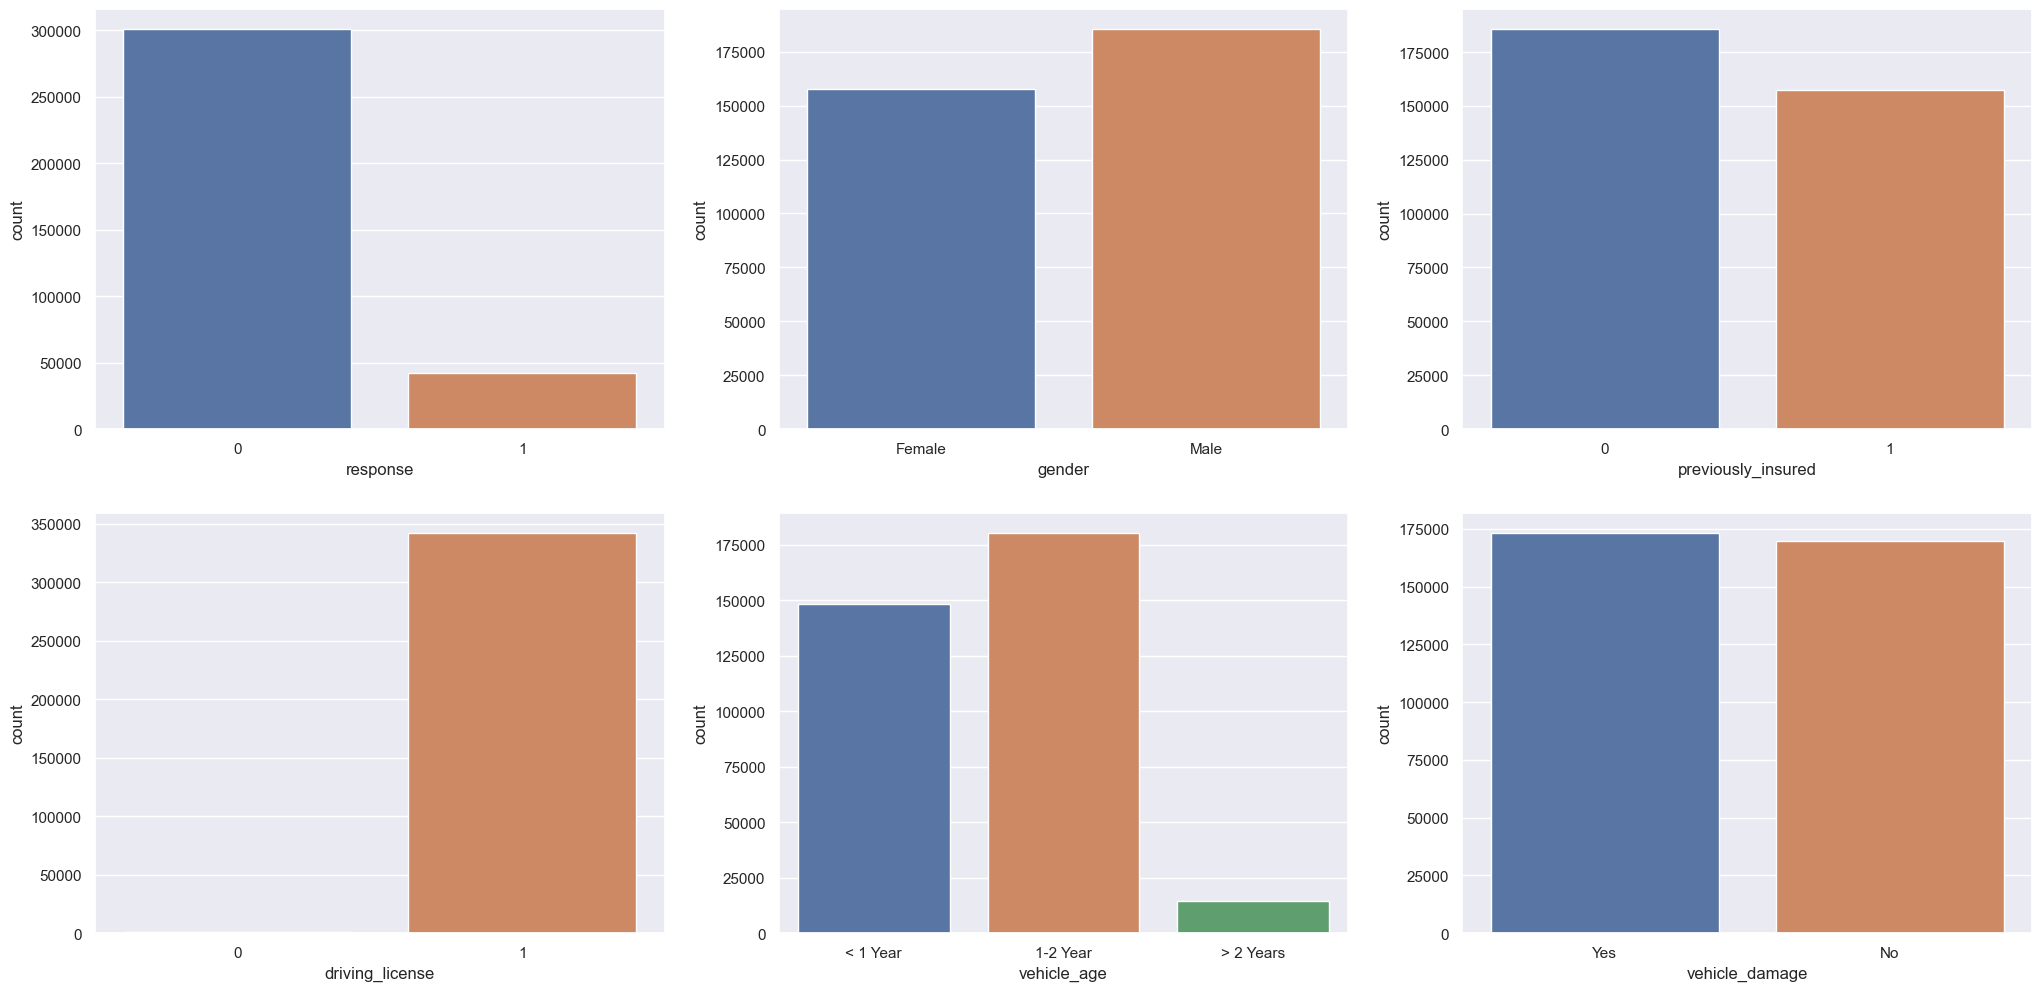

In [12]:
plt.subplot(2, 3, 1)
sns.countplot(data=cat_attributes, x='response')

plt.subplot(2, 3, 2)
sns.countplot(data=cat_attributes, x='gender')

plt.subplot(2, 3, 3)
sns.countplot(data=cat_attributes, x='previously_insured')

plt.subplot(2, 3, 4)
sns.countplot(data=cat_attributes, x='driving_license')

plt.subplot(2, 3, 5)
sns.countplot(data=cat_attributes, x='vehicle_age')

plt.subplot(2, 3, 6)
sns.countplot(data=cat_attributes, x='vehicle_damage');

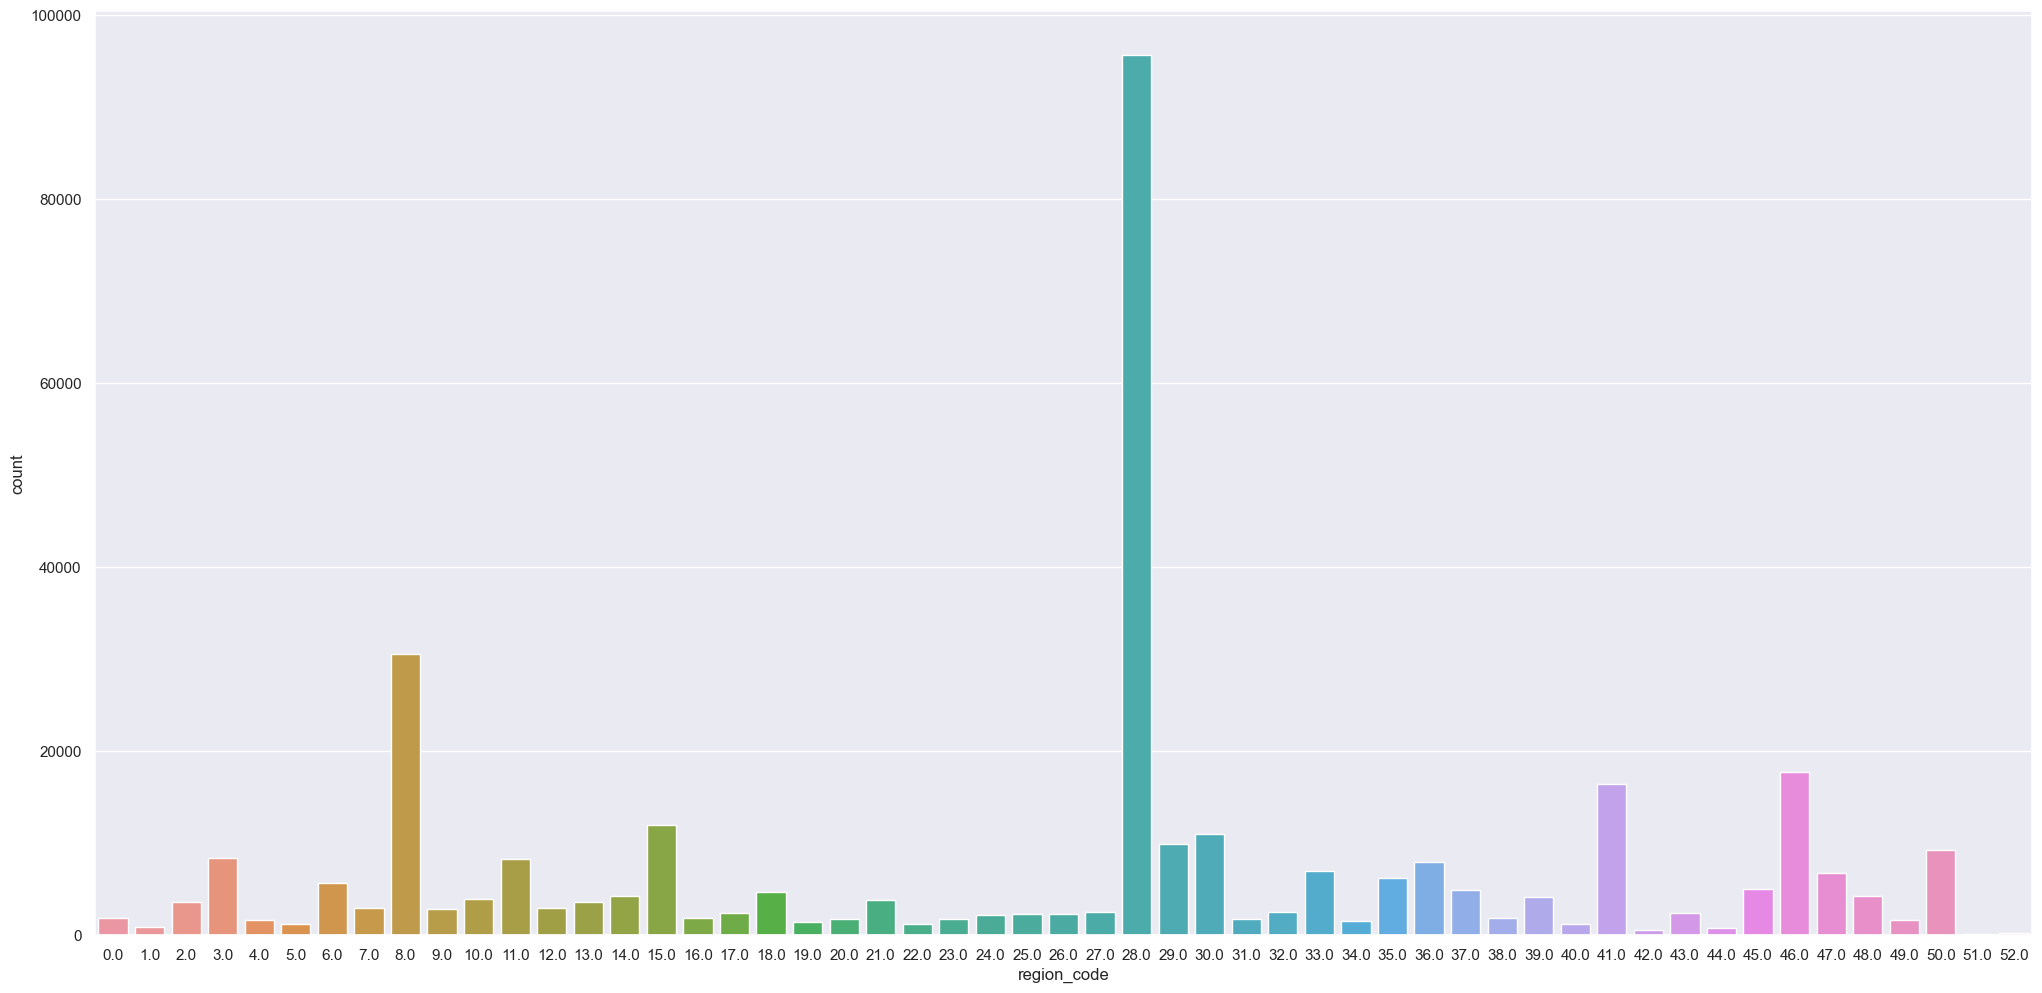

In [13]:
sns.countplot(data=cat_attributes, x='region_code');

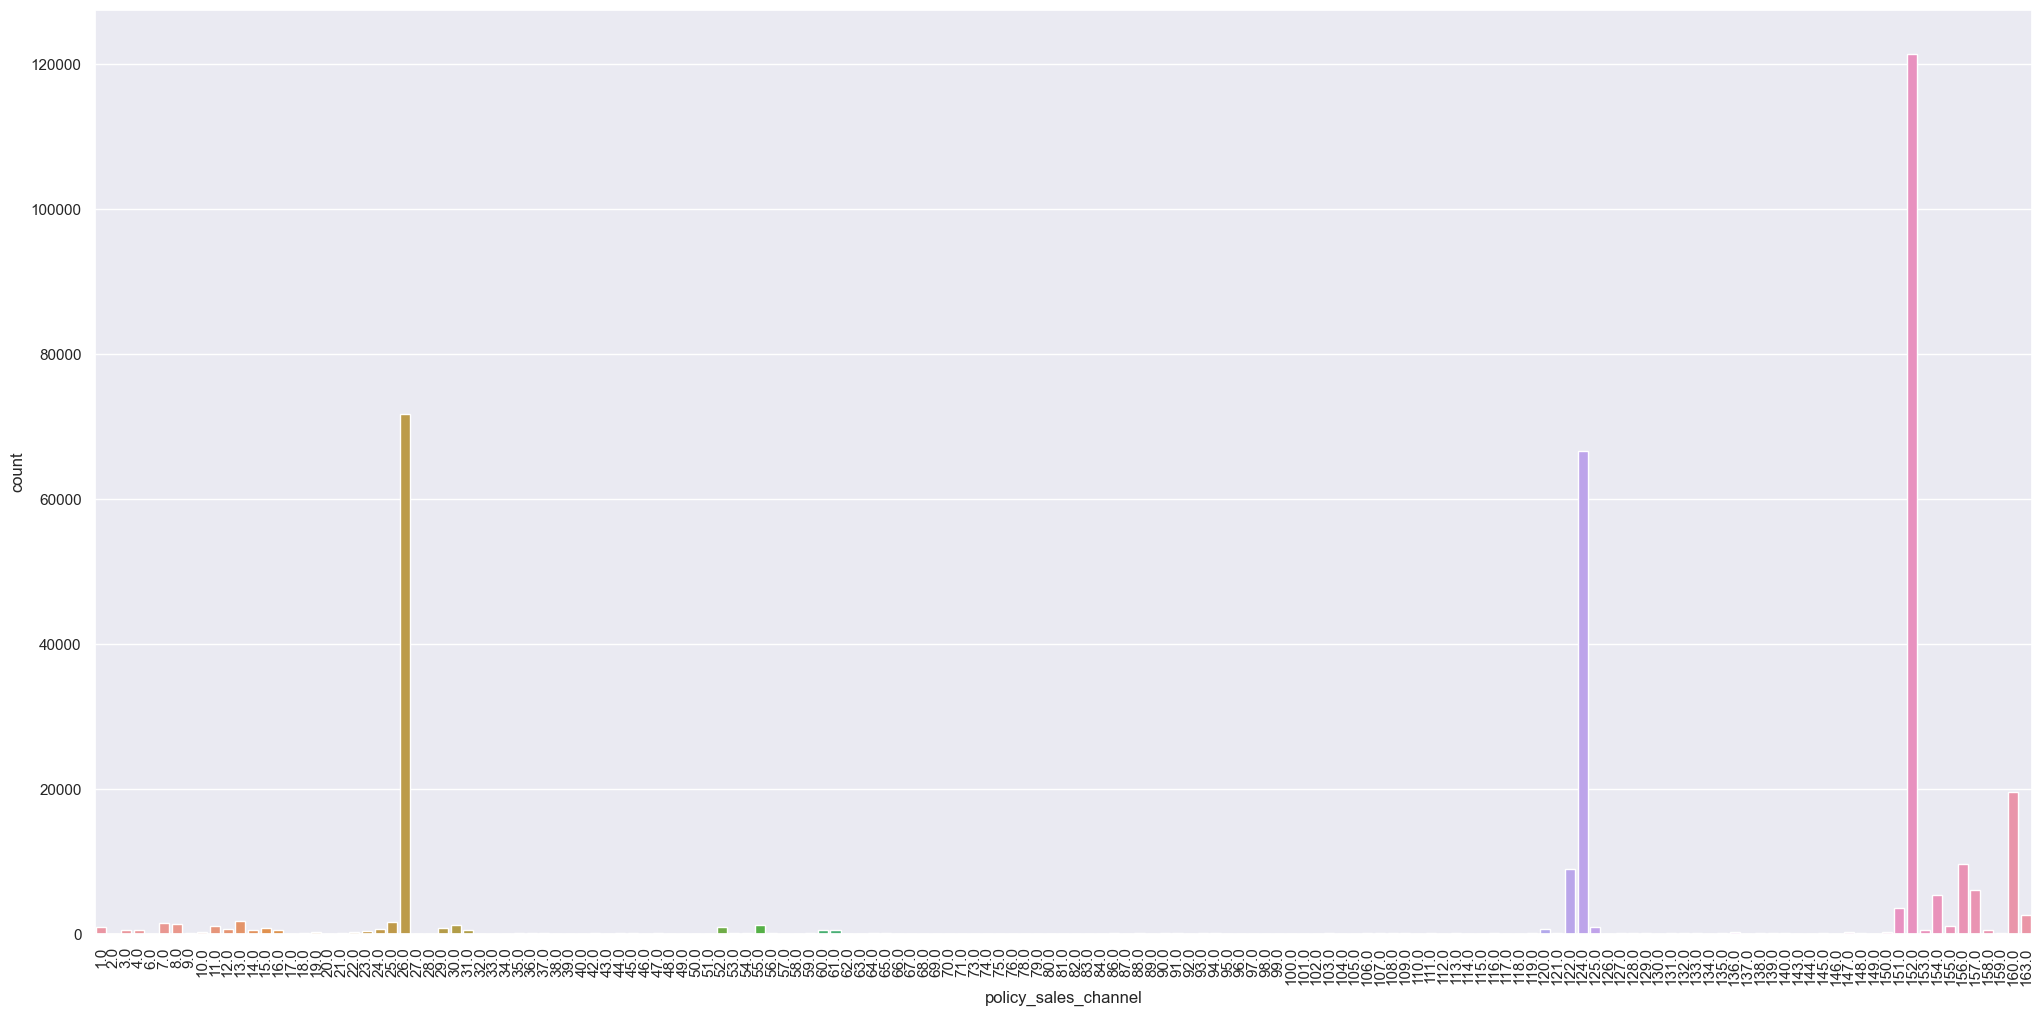

In [14]:
sns.countplot(data=cat_attributes, x='policy_sales_channel')
plt.xticks(rotation=90);

# 2. FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

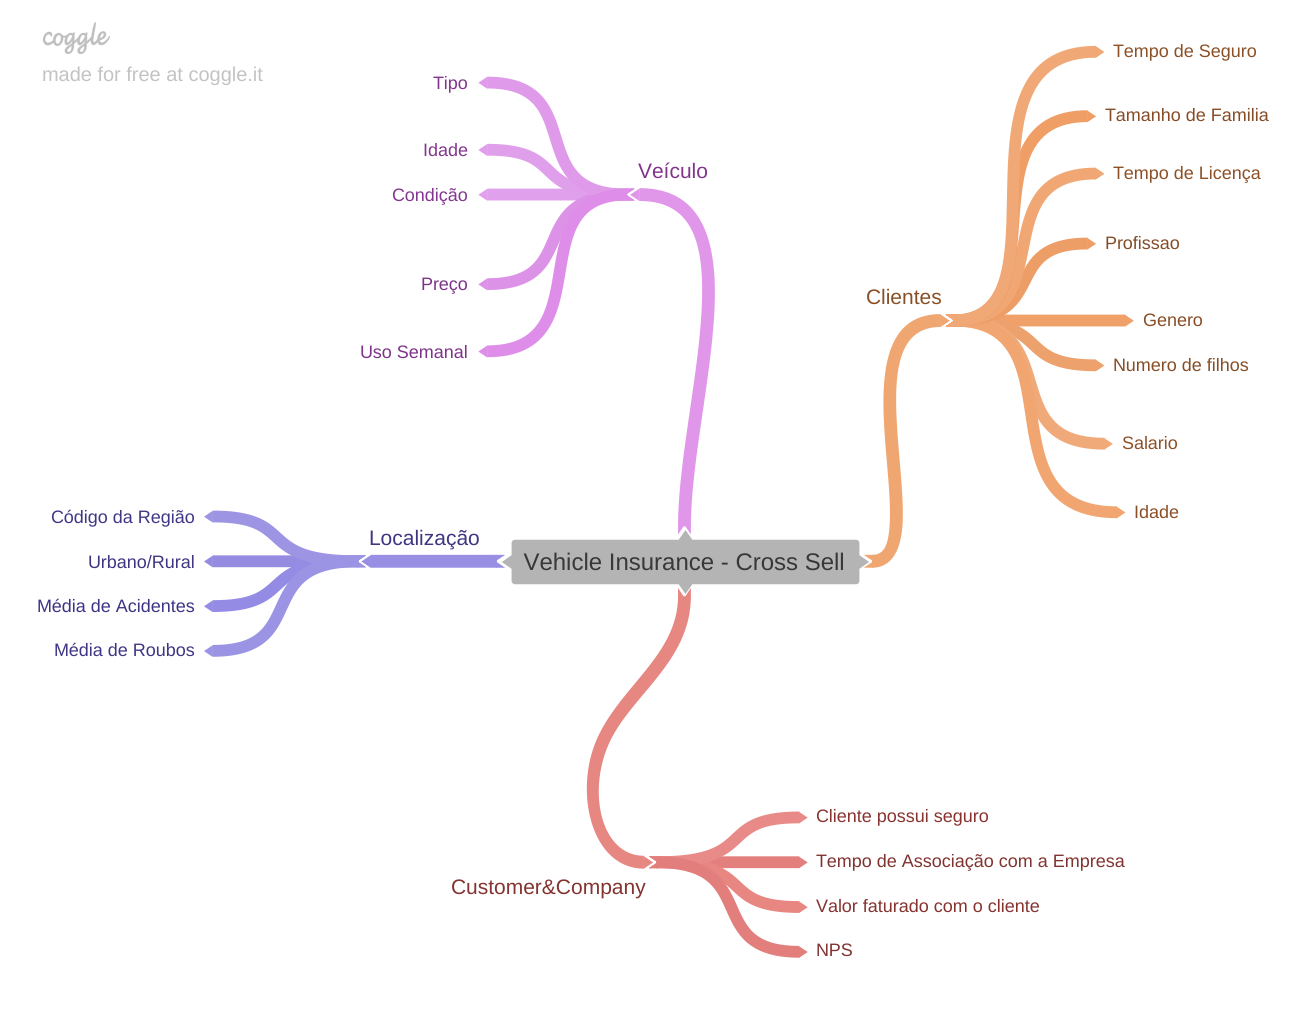

In [16]:
Image( 'images/MindMapHypothesis.png' )

## 2.2. Lista de Hipotéses

**1.** Clientes mais velhos estão mais interessados no seguro.

**2.** Clientes que ja possuem seguro estão menos interessados no seguro.

**3.** Clientes que ja tiverem o veiculo danificado estão mais interessados no seguro.

**4.** Clientes que não possuem licença para dirigir estão menos interessados no seguro.

**5.** Clientes com maior tempo de associação com a Empresa estão mais interessados no seguro.

## 2.3. Featuring Engineering

In [17]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                        'between_1_2_years' if x == '1-2 Year' else
                                                        'below_1_year')

df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

df2['40yrs_older'] = df2['age'].apply(lambda x: 1 if x >= 40 else 0)

df2['vintage_group'] = df2['vintage'].apply(lambda x: x//10 )

# 3. DATA FILTERING

Não existem dados para serem filtrados através de premissas do negócio.

# 4. EXPLORATORY DATA ANALYSIS

In [18]:
df4 = df2.copy()

## 4.1. Univariate Analysis

### 4.1.1. Numerical Variables

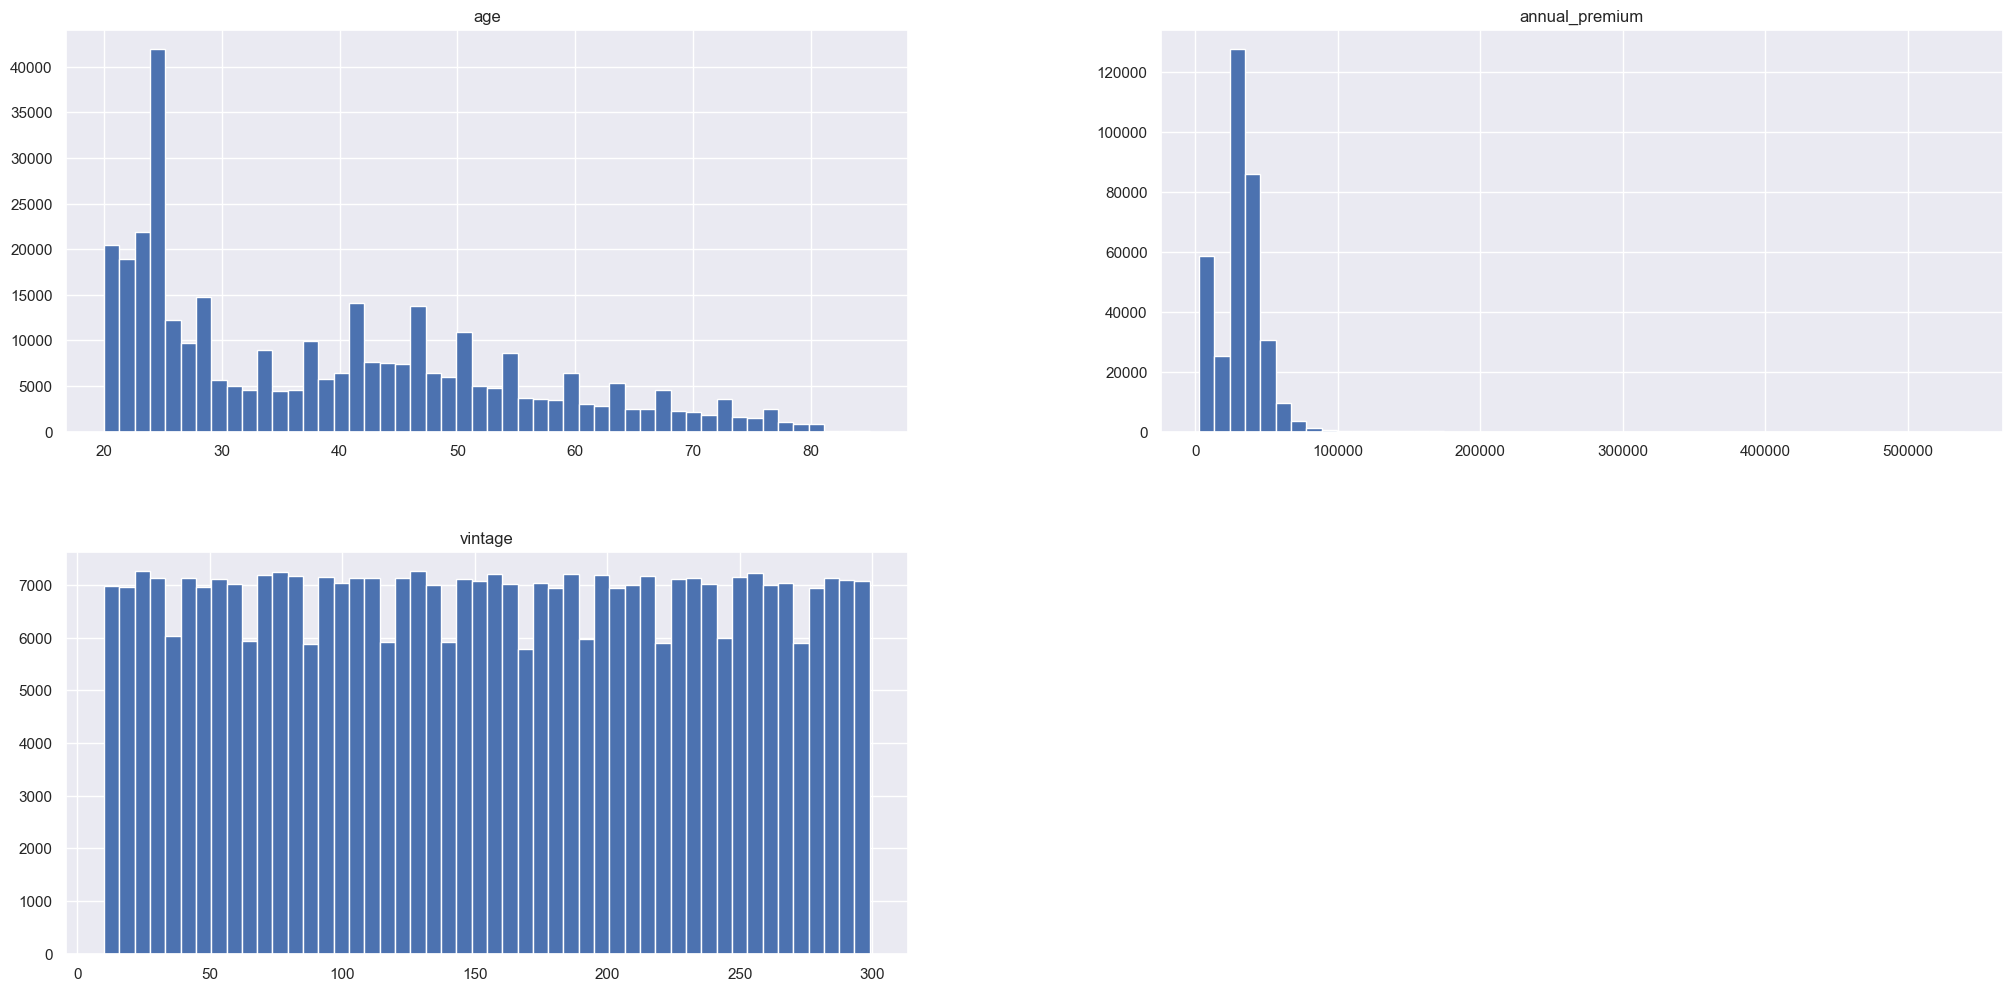

In [19]:
num_attributes.hist(bins=50);

### 4.1.2. Categorical Variables

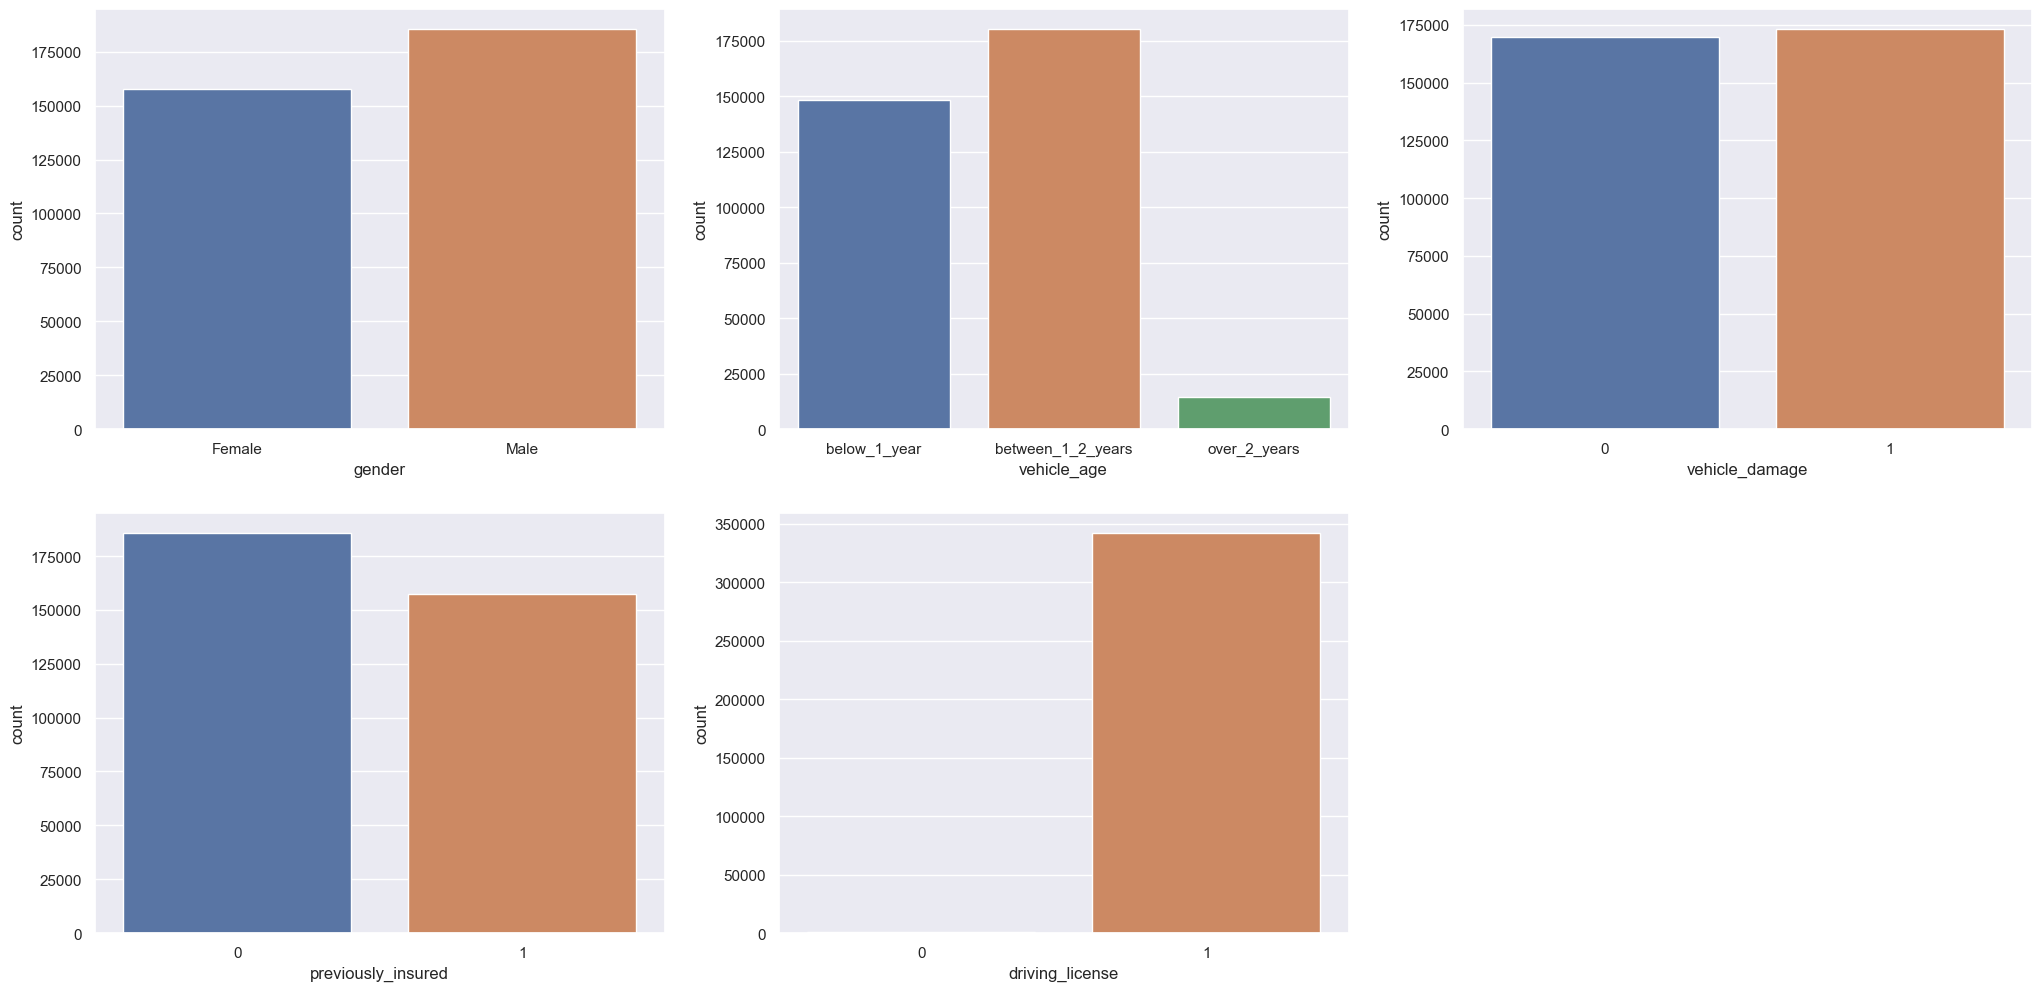

In [20]:
# gender
plt.subplot(2, 3, 1)
sns.countplot( x=df4['gender'] )

# vehicle_age
plt.subplot(2, 3, 2)
sns.countplot( x=df4['vehicle_age'] )

# vehicle_damage
plt.subplot(2, 3, 3)
sns.countplot( x=df4['vehicle_damage'] )

# previously_insured
plt.subplot(2, 3, 4)
sns.countplot( x=df4['previously_insured'] )

# driving_license
plt.subplot(2, 3, 5)
sns.countplot( x=df4['driving_license'] );


### 4.1.3. Target Variable

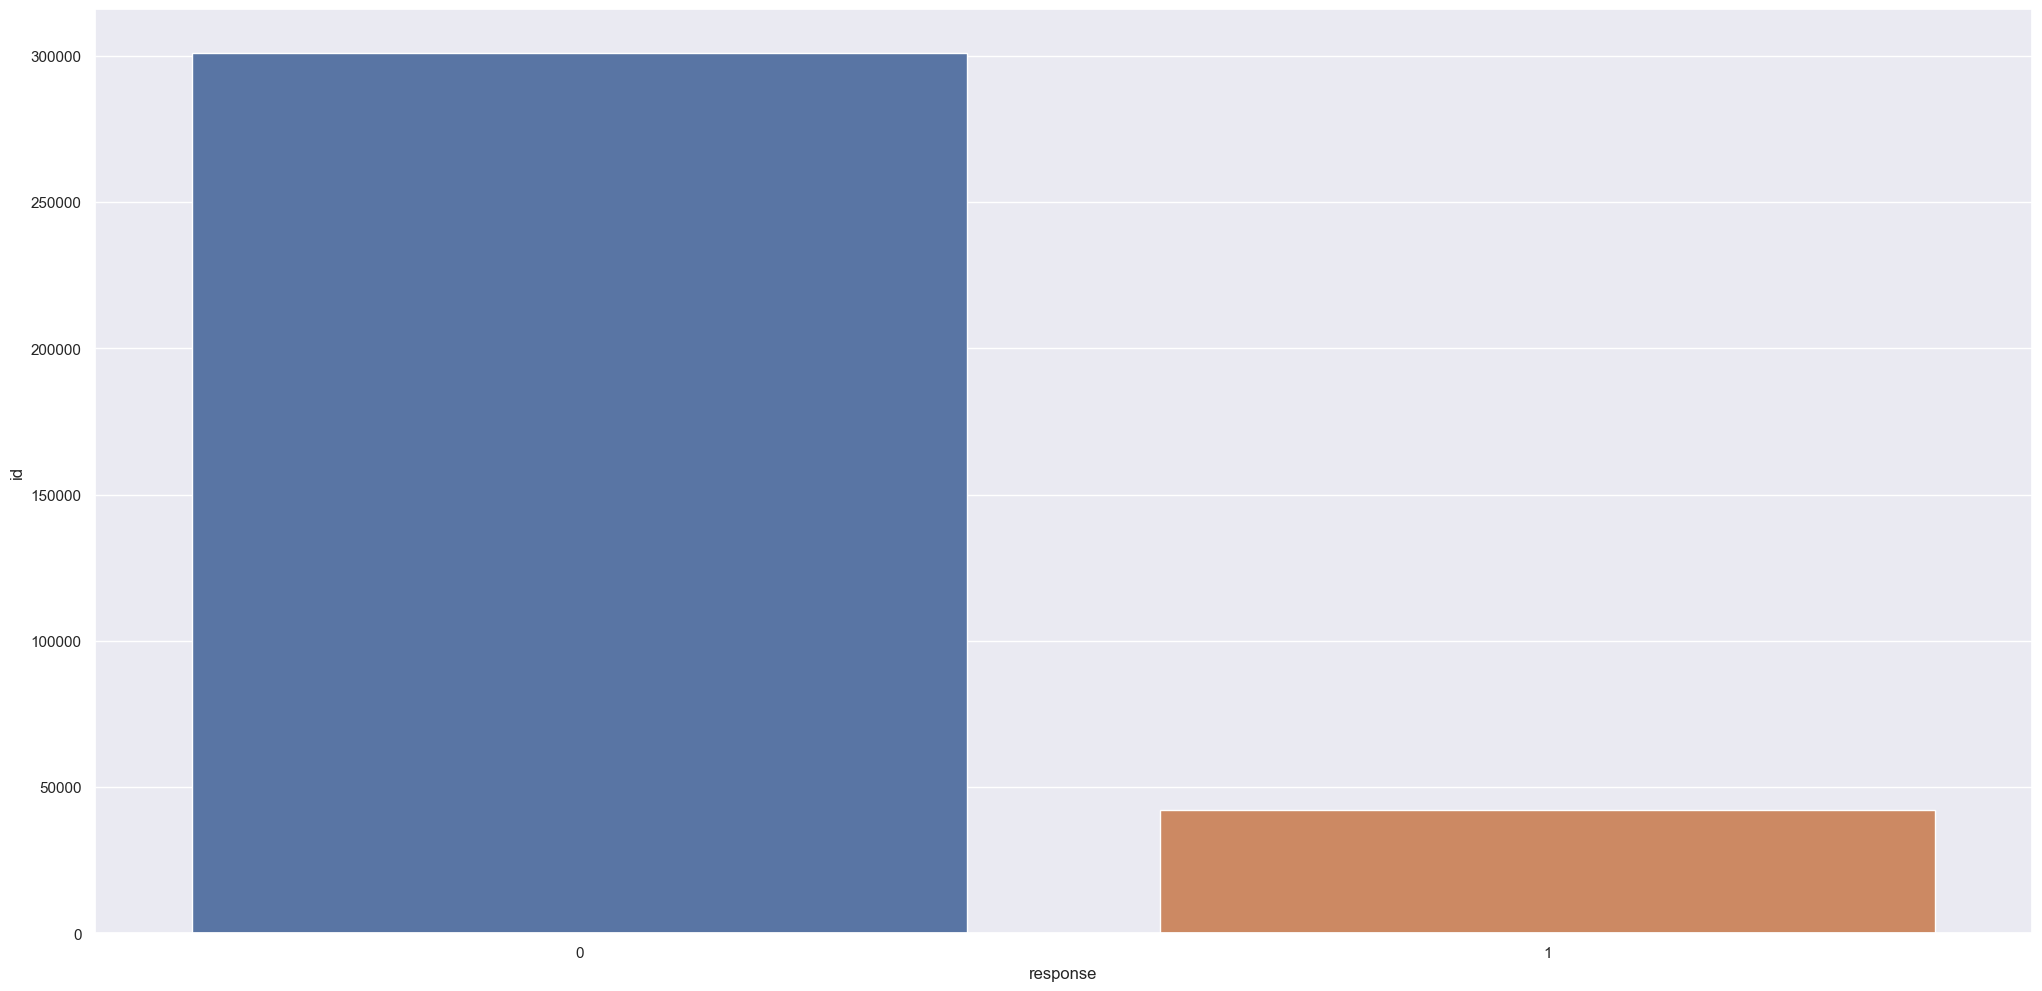

In [22]:
aux = df4[['id', 'response']].groupby('response').count().reset_index()
sns.barplot(data=aux, x='response', y='id');

In [114]:
print(f'A categoria zero possui {aux["id"][0]/aux["id"].sum():.2%} dos dados, enquanto a categoria 1 possui {aux["id"][1]/aux["id"].sum():.2%}.')

A categoria zero possui 87.72% dos dados, enquanto a categoria 1 possui 12.28%.


## 4.2. Analise Bivariada

### 4.2.1. age

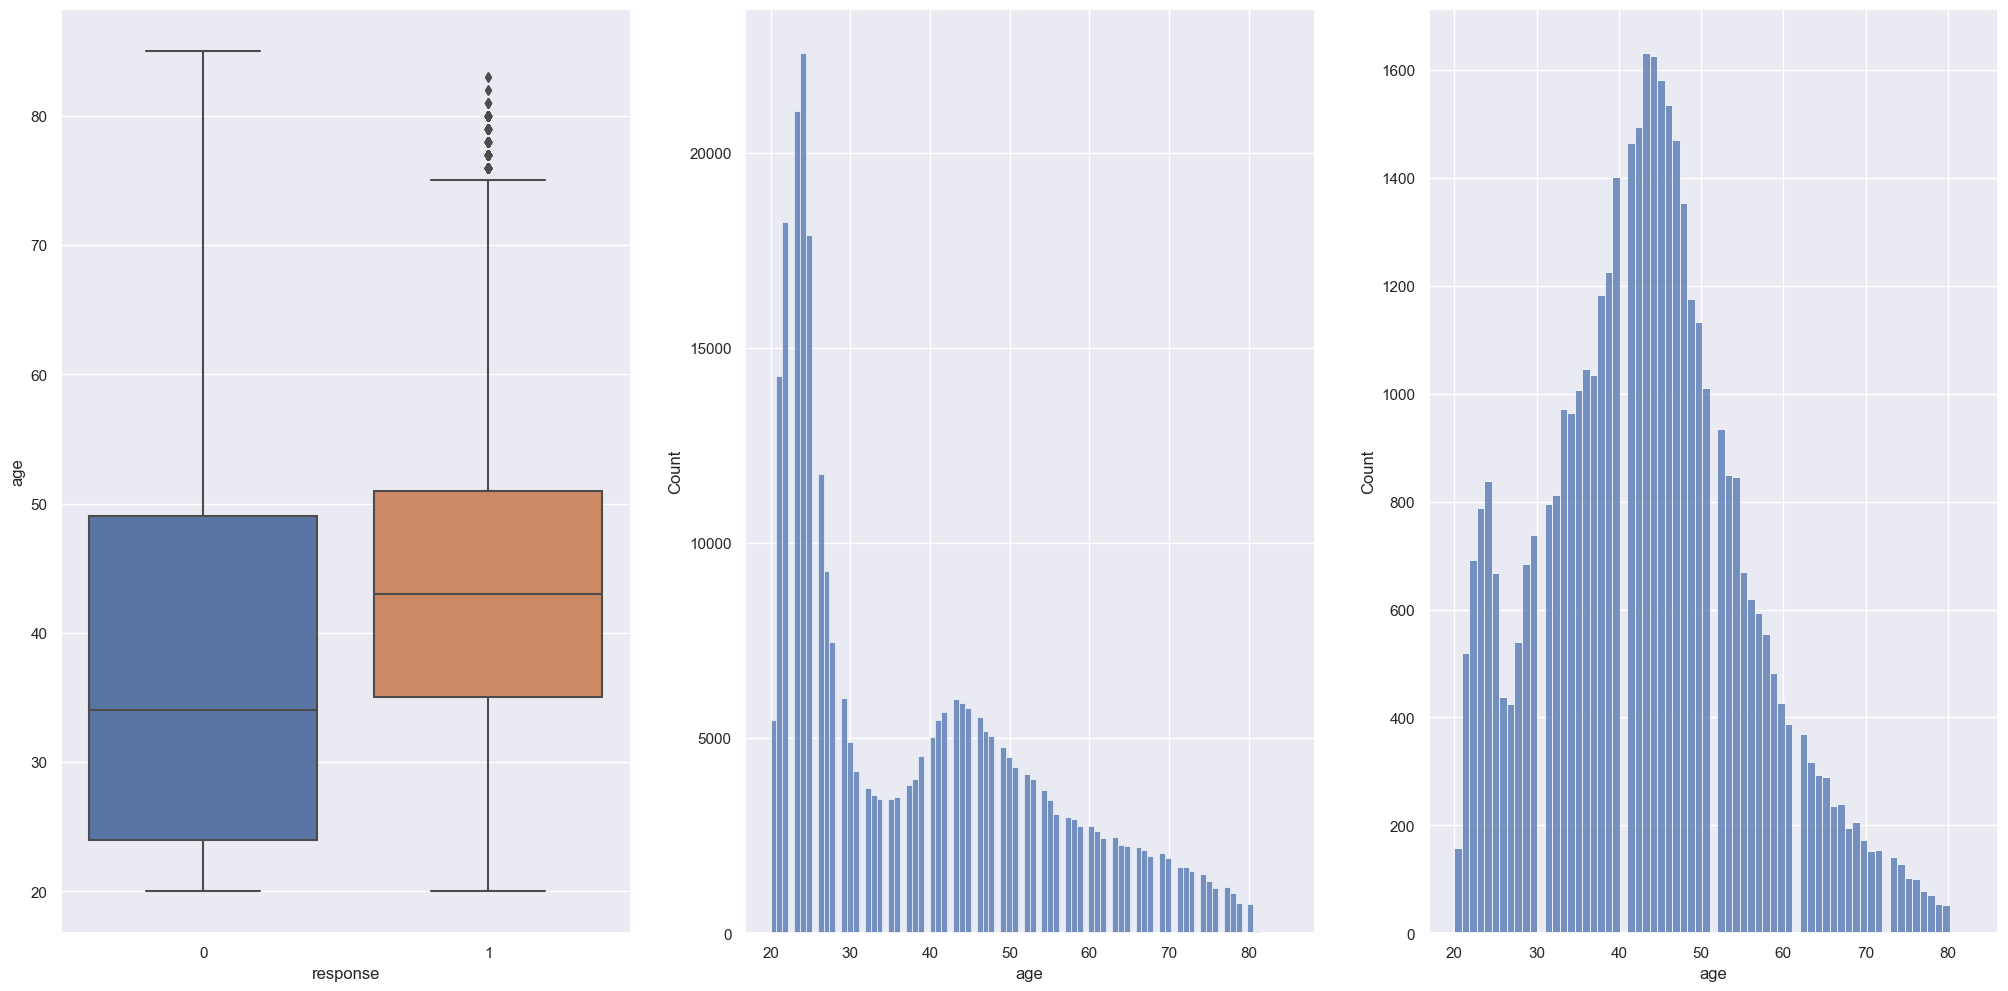

In [23]:
plt.subplot(1,3,1)
sns.boxplot(x='response', y='age', data=df4);

plt.subplot(1,3,2)
sns.histplot(df4.loc[df4['response']==0, 'age'])

plt.subplot(1,3,3)
sns.histplot(df4.loc[df4['response']==1, 'age']);


### 4.2.2. driving_license

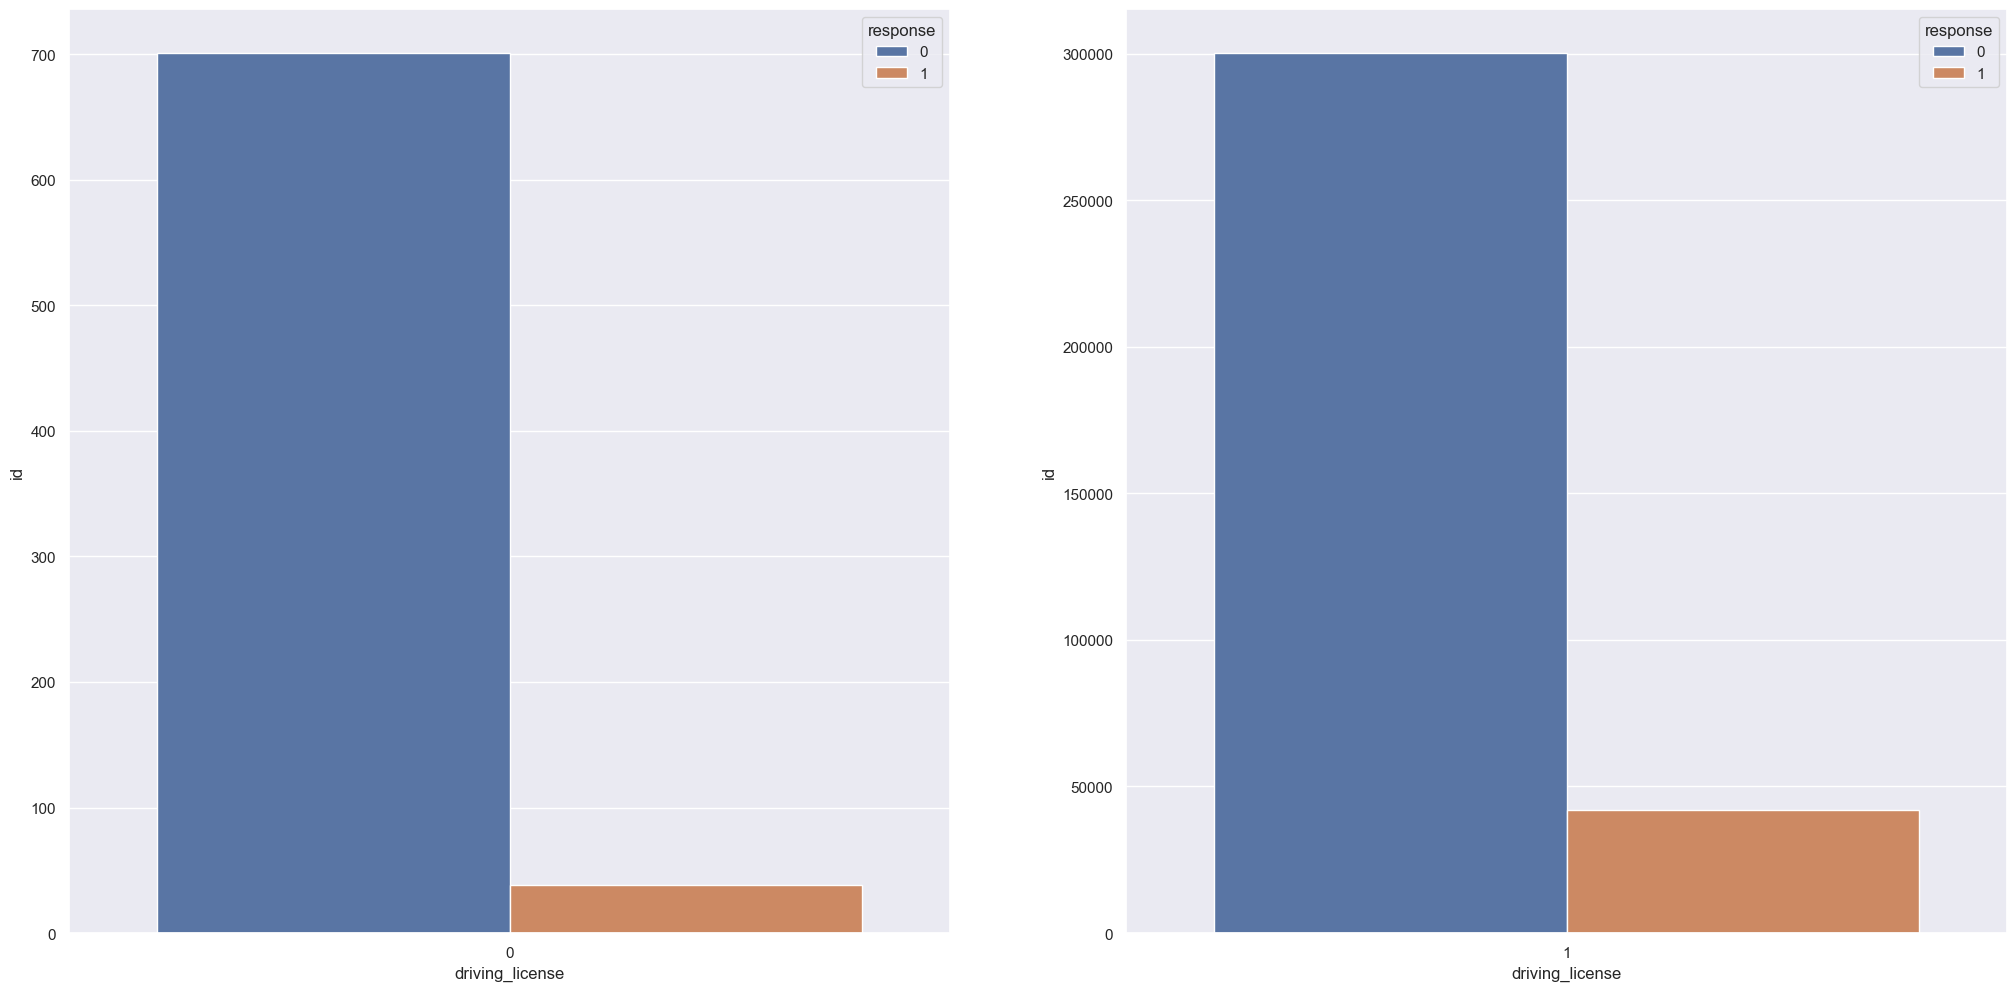

In [24]:
#driving_license
aux = df4[['id', 'response', 'driving_license']].groupby(['response', 'driving_license']).count().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='driving_license', y='id', hue='response', data=aux[aux['driving_license']==0])

plt.subplot(1, 2, 2)
sns.barplot(x='driving_license', y='id', hue='response', data=aux[aux['driving_license']==1]);

### 4.2.3. region_code

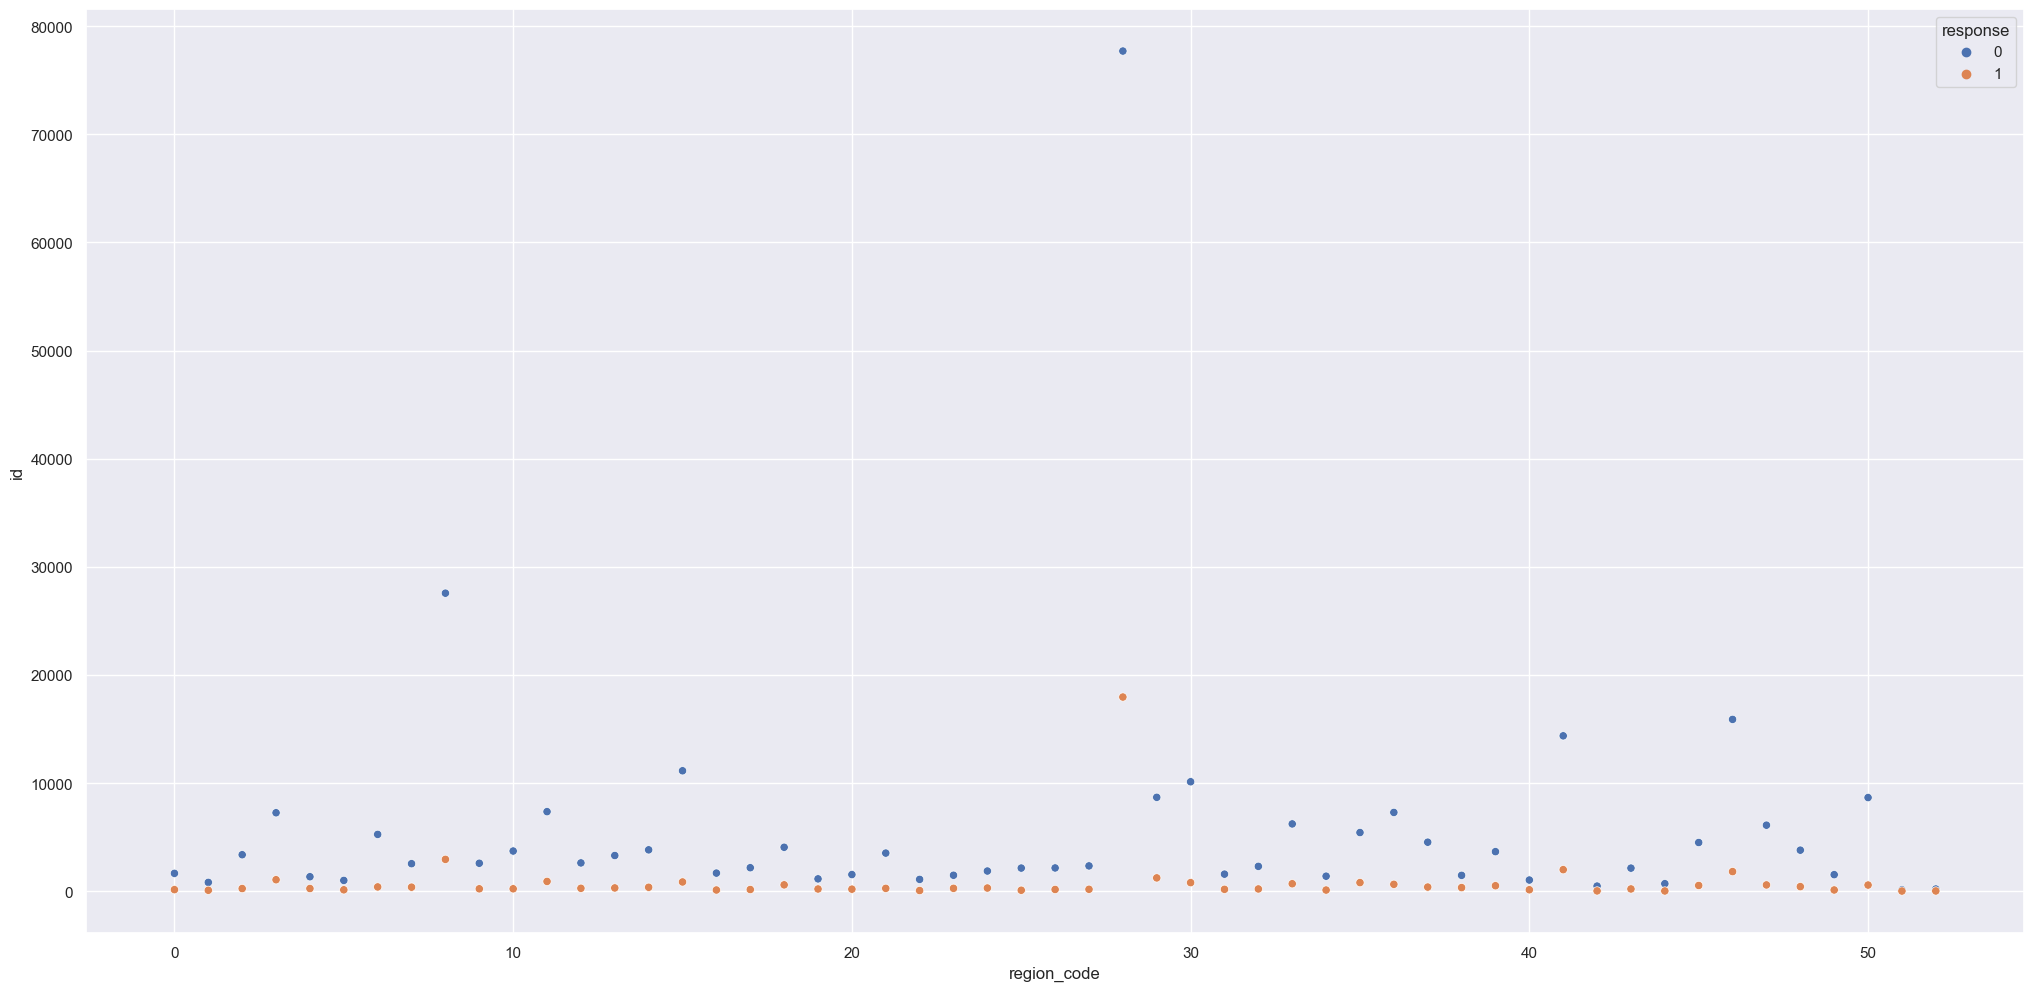

In [25]:
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

### 4.2.4. previously_insured

In [26]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.773871,0.226129
1,0.999135,0.000865


### 4.2.4. vehicle_age

In [27]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().sort_values(by=['vehicle_age'])

,vehicle_age,response,0
1,below_1_year,0,0.413731
4,below_1_year,1,0.018936
0,between_1_2_years,0,0.433825
2,between_1_2_years,1,0.091534
3,over_2_years,0,0.029618
5,over_2_years,1,0.012356


### 4.2.5. policy_sales_channel

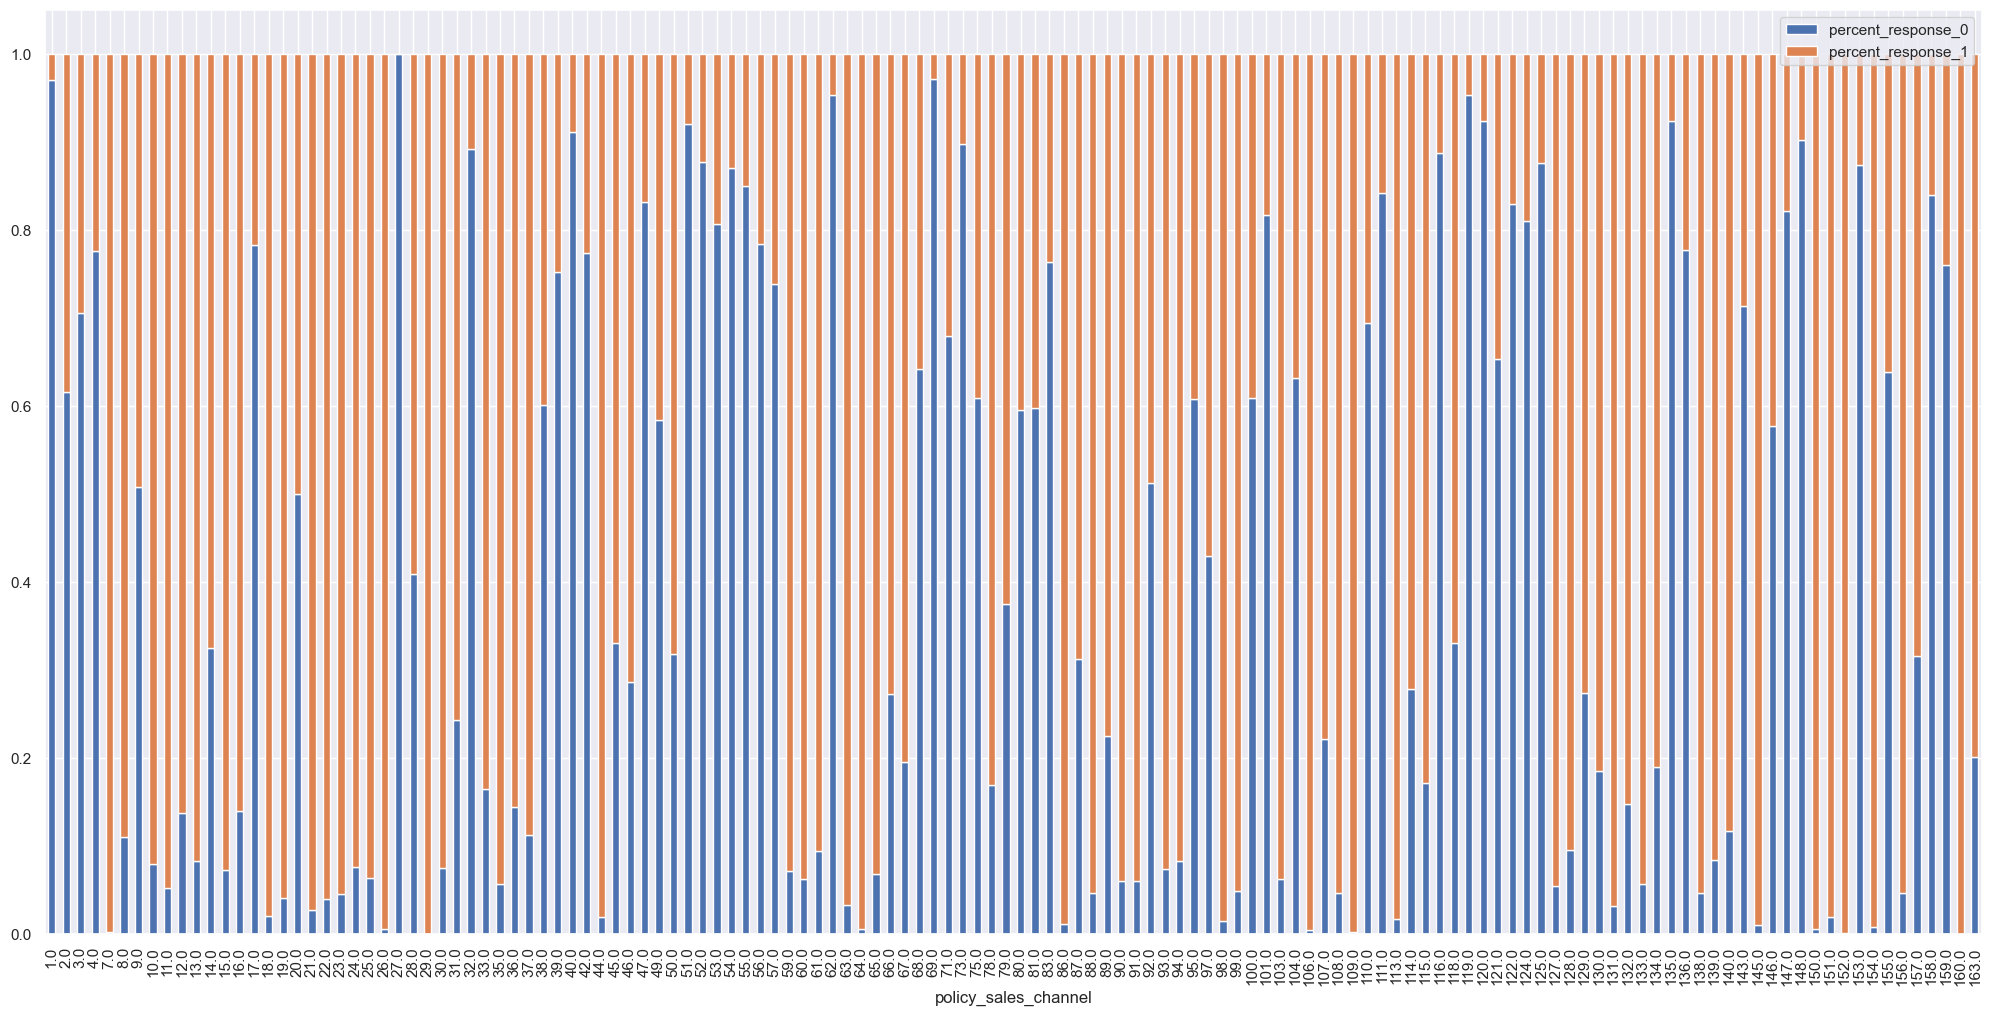

In [28]:
aux = df4[['id','policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).sum().reset_index()
aux1 = pd.DataFrame(columns = ['policy_sales_channel', 'count_response_0', 'count_response_1'])
j=0
for i in range(1,len(aux),2):
    aux1.loc[j] = pd.Series({'policy_sales_channel': aux['policy_sales_channel'][i], 'count_response_0':int(aux['id'][i-1]),
                            'count_response_1': int(aux['id'][i])})
    j += 1
aux1['percent_response_0'] = aux1.apply(lambda x: x['count_response_0']/ (x['count_response_0']+x['count_response_1']), axis=1)
aux1['percent_response_1'] = aux1.apply(lambda x: x['count_response_1']/ (x['count_response_0']+x['count_response_1']), axis=1)

aux1[['policy_sales_channel','percent_response_0', 'percent_response_1']].set_index('policy_sales_channel').plot(kind='bar', stacked=True);

### 4.2.6. vintage

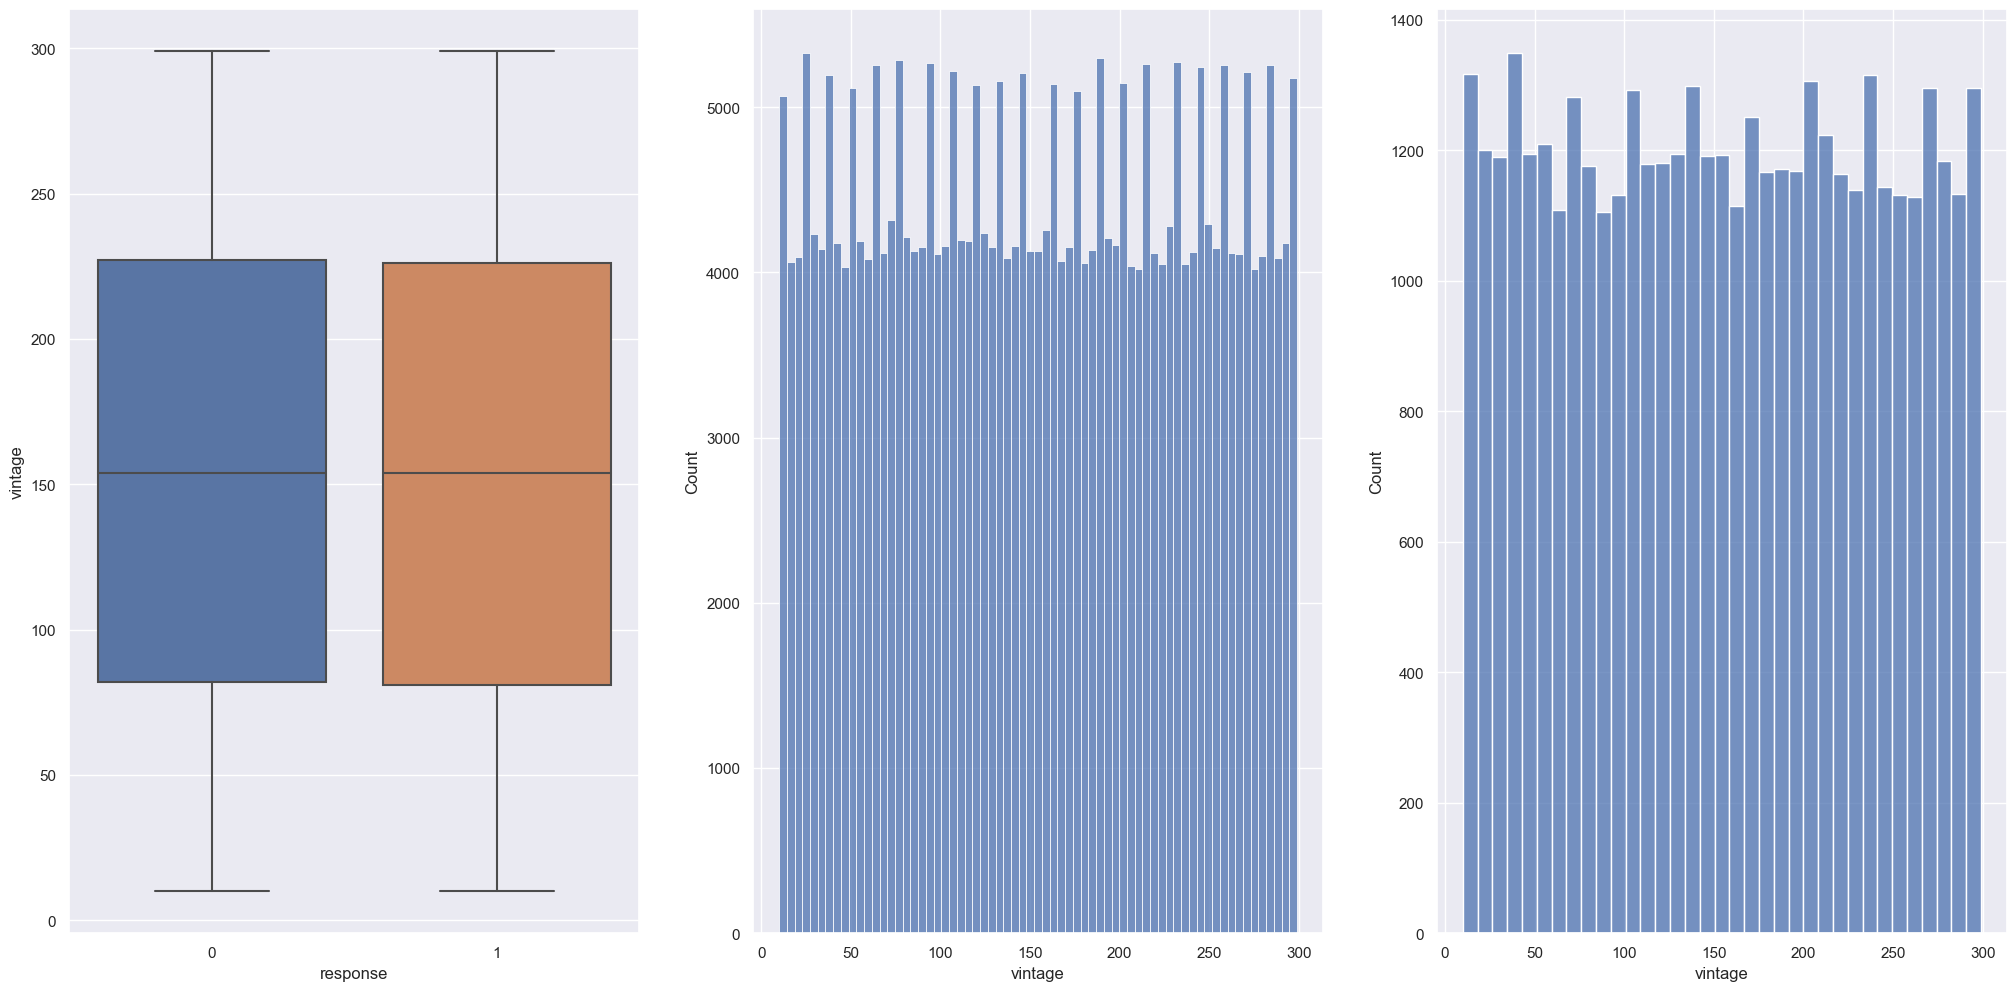

In [29]:
#vintage
plt.subplot(1,3,1)
sns.boxplot(x='response', y='vintage', data=df4);

plt.subplot(1,3,2)
sns.histplot(df4[df4['response']==0]['vintage'])

plt.subplot(1,3,3)
sns.histplot(df4[df4['response']==1]['vintage']);

### 4.2.7. annual_premium

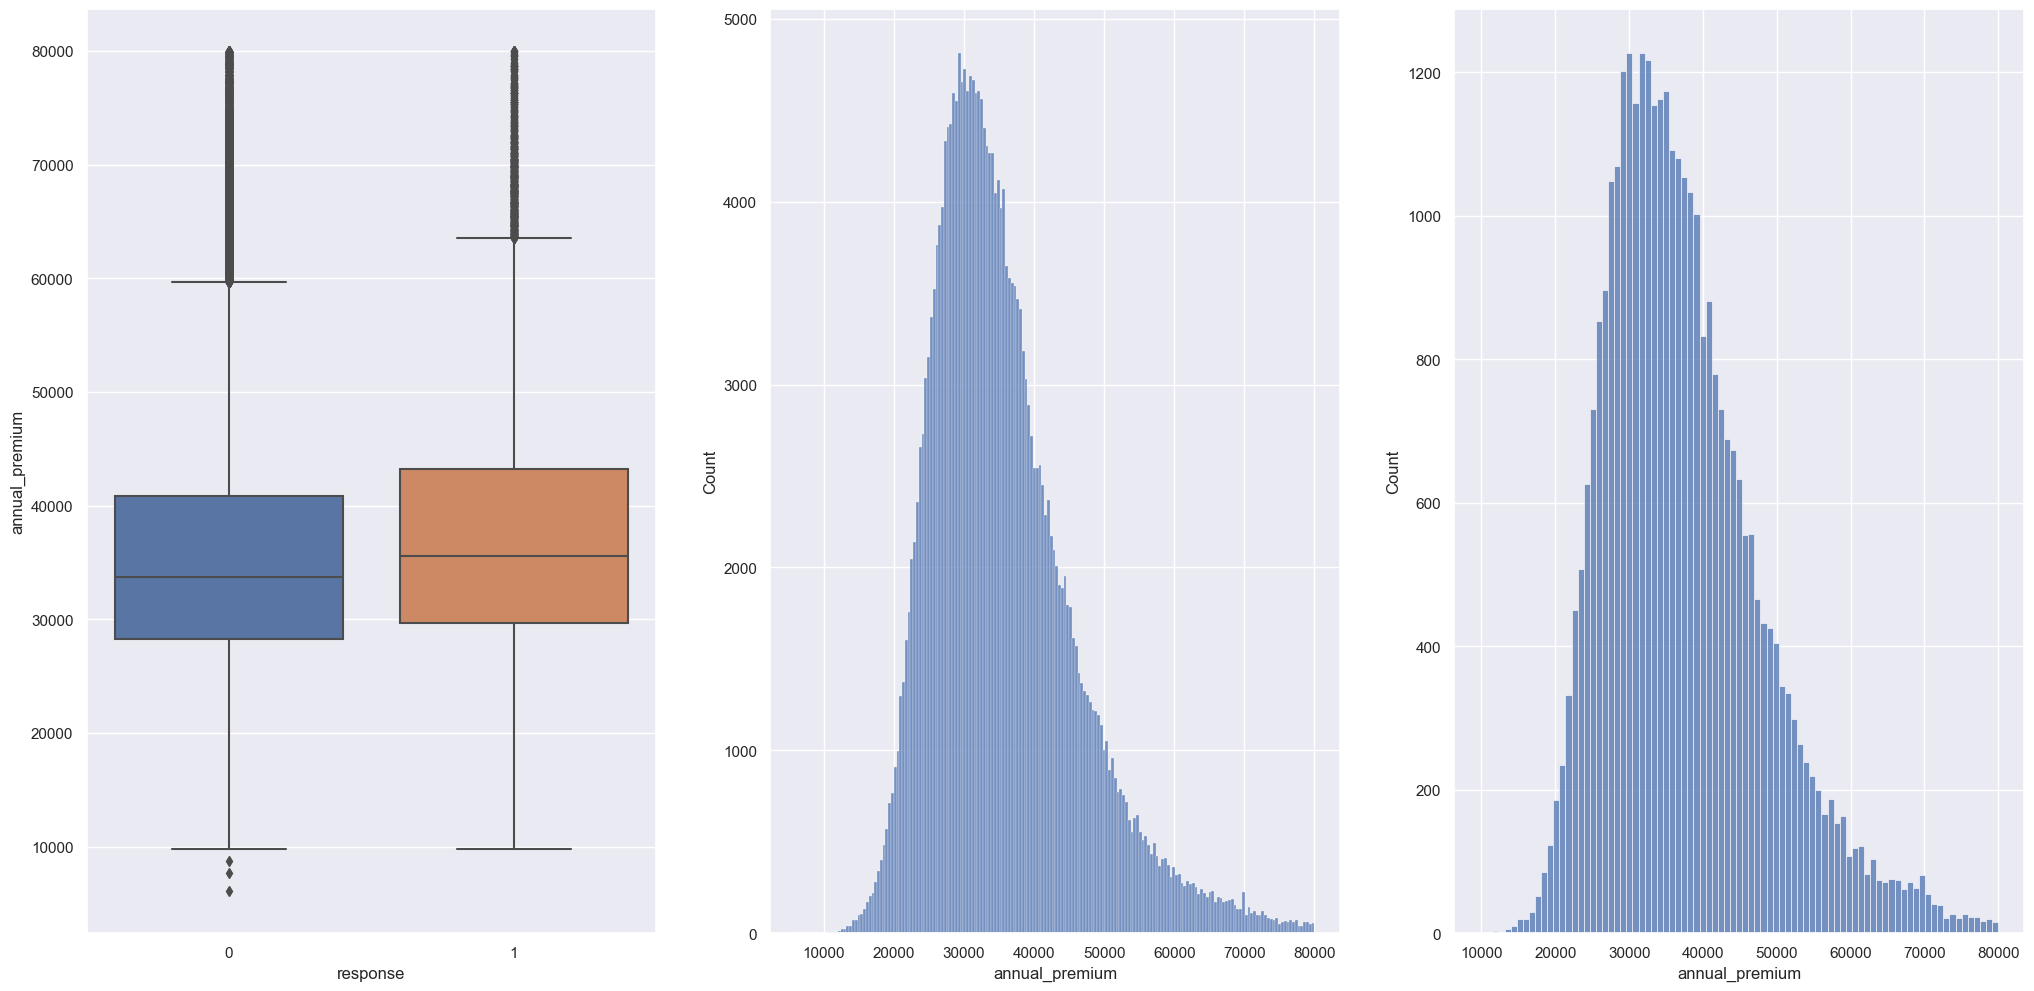

In [30]:
aux = df4[(df4['annual_premium'] > 5000) & (df4['annual_premium'] < 80000)][['response', 'annual_premium']]
plt.subplot(1,3,1)
sns.boxplot(x='response', y='annual_premium', data=aux);

plt.subplot(1,3,2)
sns.histplot(aux[aux['response']==0]['annual_premium'])

plt.subplot(1,3,3)
sns.histplot(aux[aux['response']==1]['annual_premium']);

### 4.2.8. gender

In [31]:
pd.crosstab(df4['gender'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
gender,,
Female,0.896052,0.103948
Male,0.861149,0.138851


### 4.2.9. driving_license

In [32]:
pd.crosstab(df4['driving_license'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
driving_license,,
0,0.948579,0.051421
1,0.877020,0.122980


### 4.2.10. vehicle_damage

In [33]:
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.994812,0.005188
1,0.761827,0.238173


### 4.2.11. Hipoteses

**1.** Clientes mais velhos estão mais interessados no seguro.

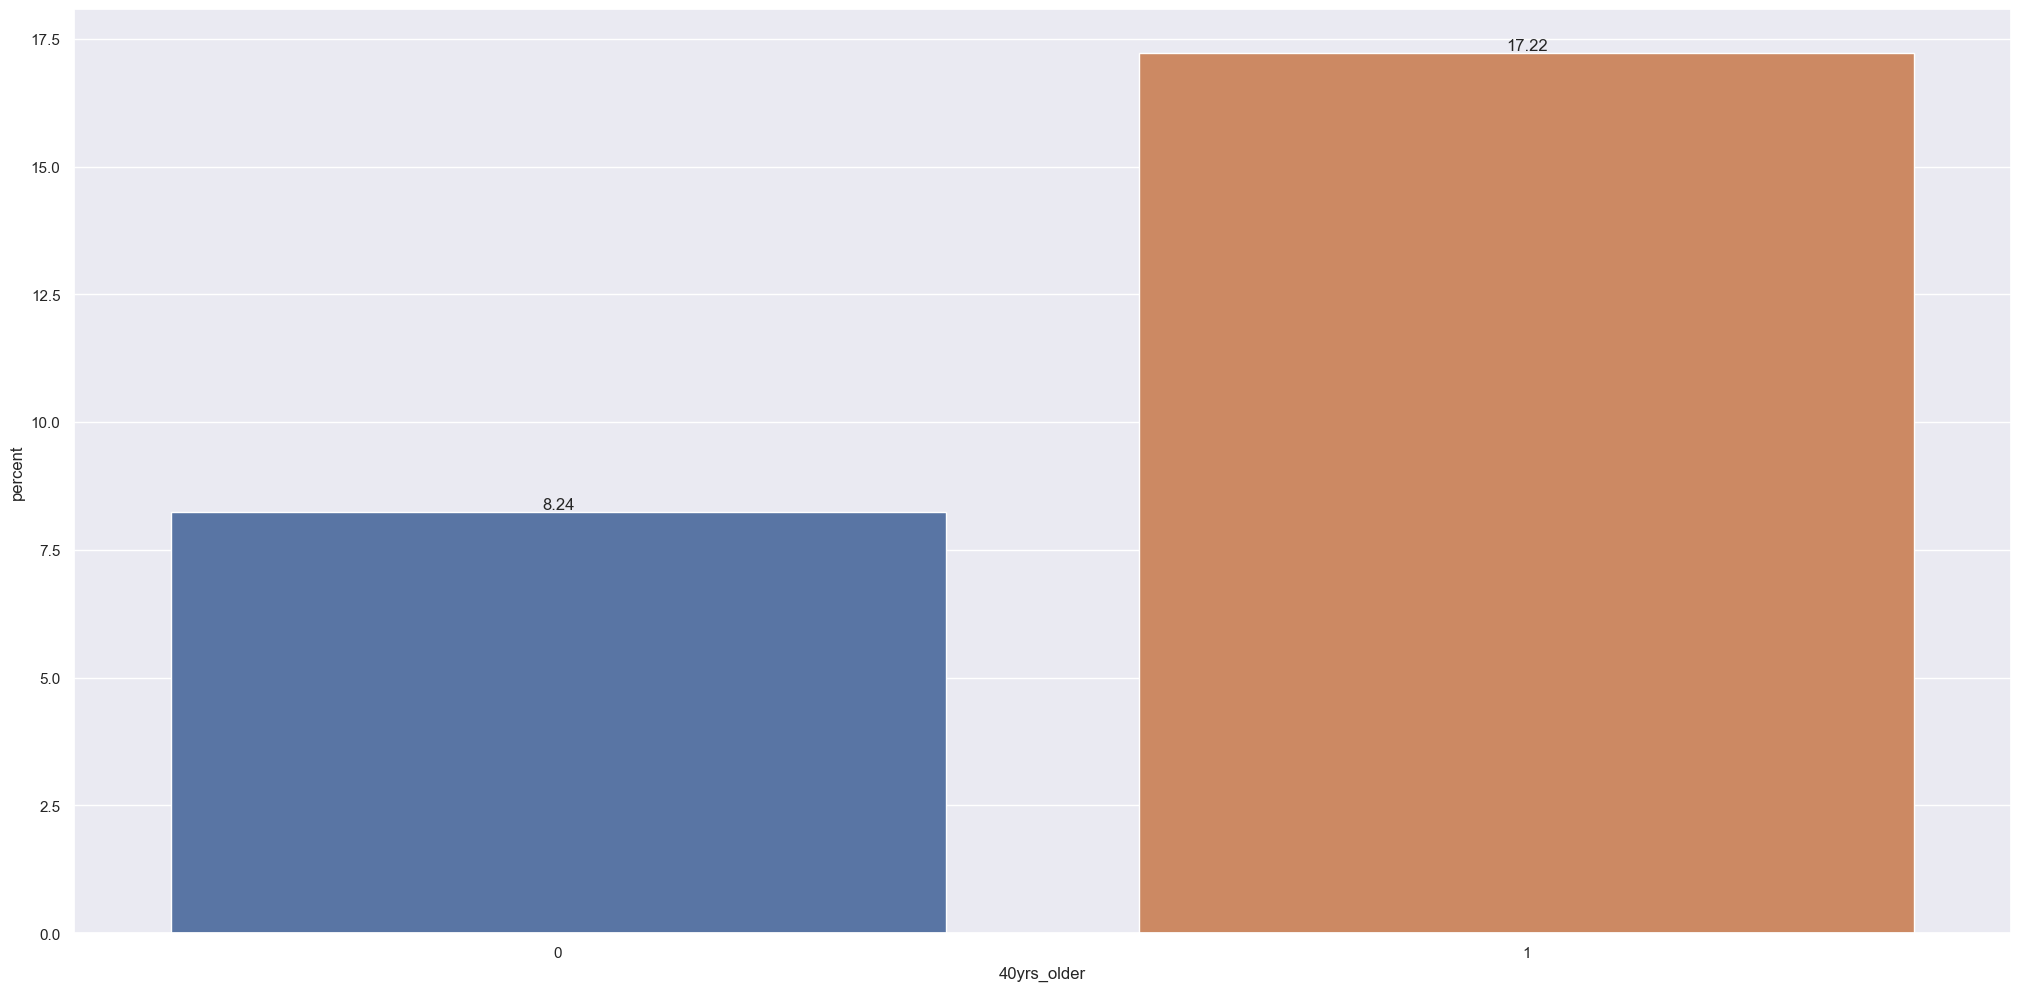

In [34]:
aux = df4[['40yrs_older', 'response']].groupby('40yrs_older')
aux1 = aux.sum().reset_index().merge(aux.count().reset_index(), on='40yrs_older')
aux1.columns = ['40yrs_older', 'response_1', 'count']
aux1['percent'] = aux1['response_1']*100/aux1['count']

ax = sns.barplot(data=aux1, x='40yrs_older', y='percent')
ax.bar_label(ax.containers[0], fmt='%.2f');

**Verdadeiro.** Dentre os clientes com 40 anos ou mais 17,22% possuem um interesse, enquanto apenas 8,24% dos clientes com menos de 40 anos possuem interesse.

**2.** Clientes que ja possuem seguro estão menos interessados no seguro.

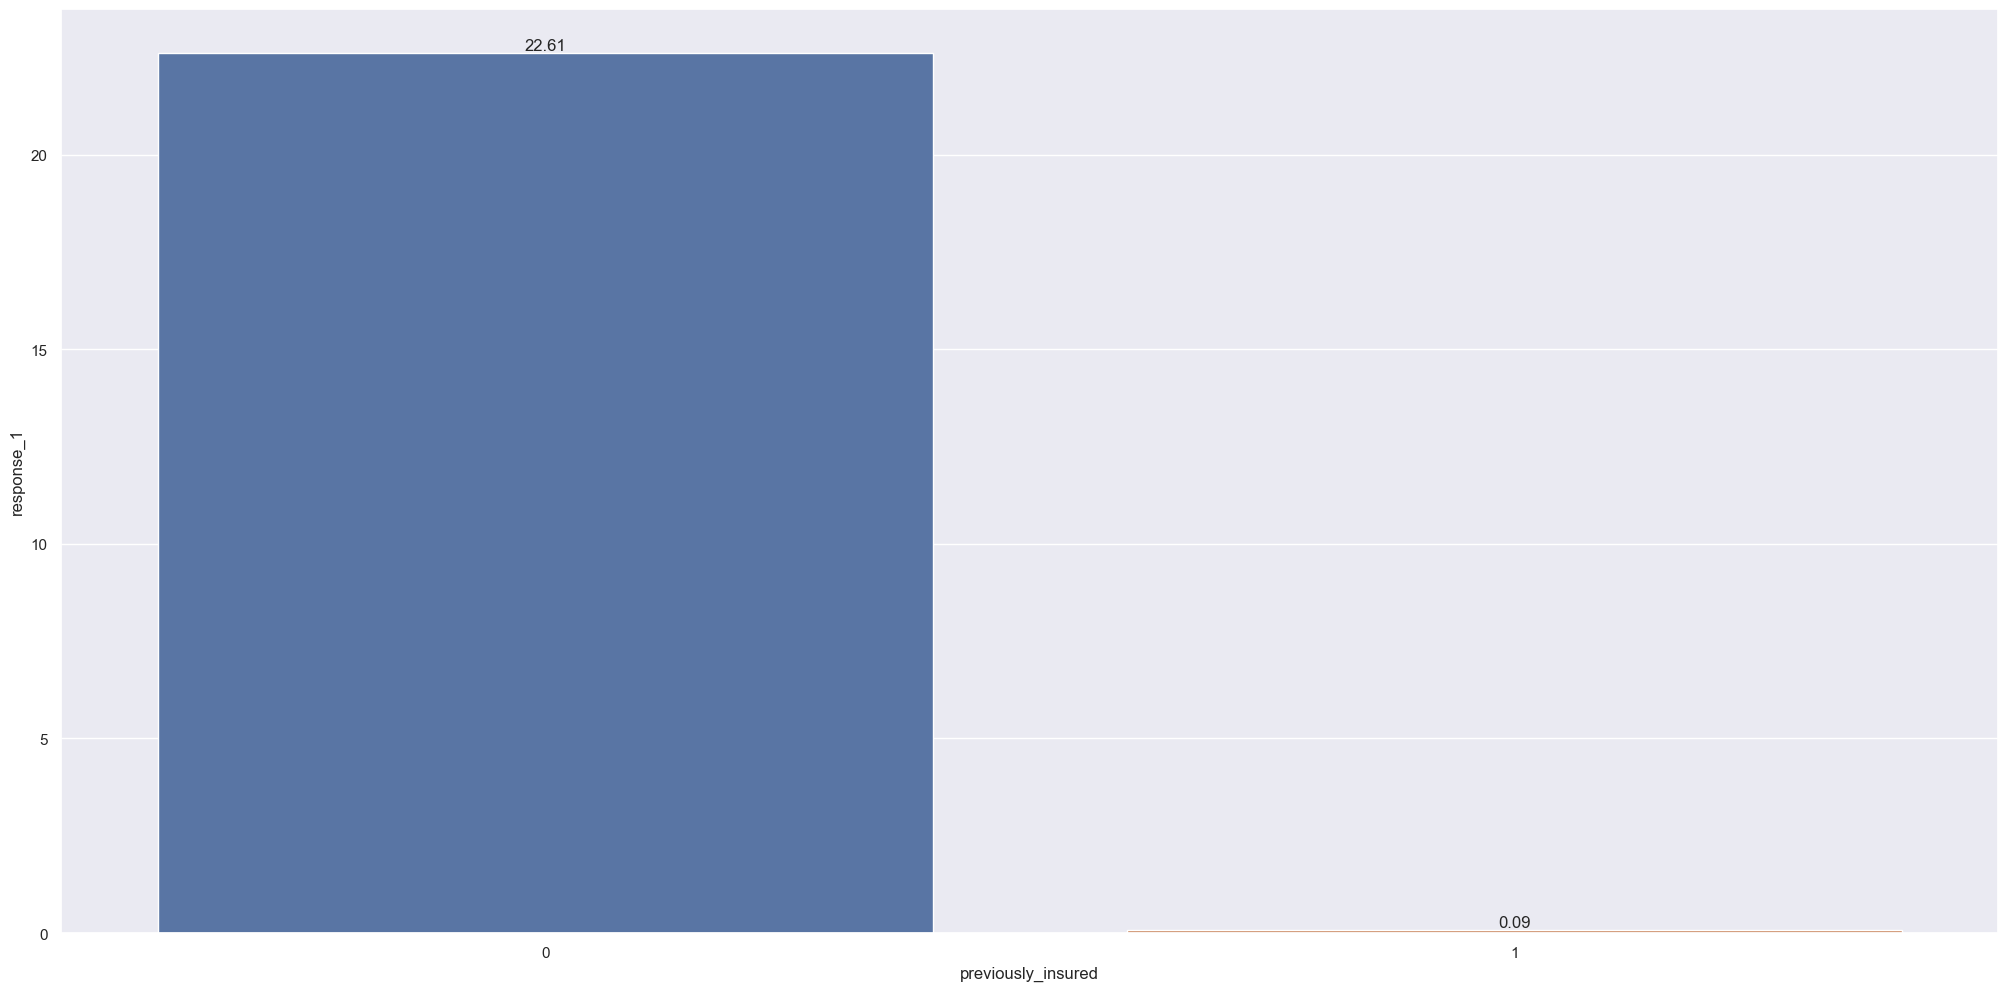

In [35]:
aux = pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()


aux.columns = ['previously_insured', 'response_0', 'response_1']
aux[['response_0', 'response_1']] = aux[['response_0', 'response_1']]*100

ax = sns.barplot(data=aux, x='previously_insured', y='response_1')
ax.bar_label(ax.containers[0], fmt='%.2f');

**Verdadeiro.** Dentre os clientes que não possuem seguro 22,61% possuem um interesse, enquanto apenas 0,09% dos clientes com seguro possuem interesse.

**3.** Clientes que ja tiverem o veiculo danificado estão mais interessados no seguro.

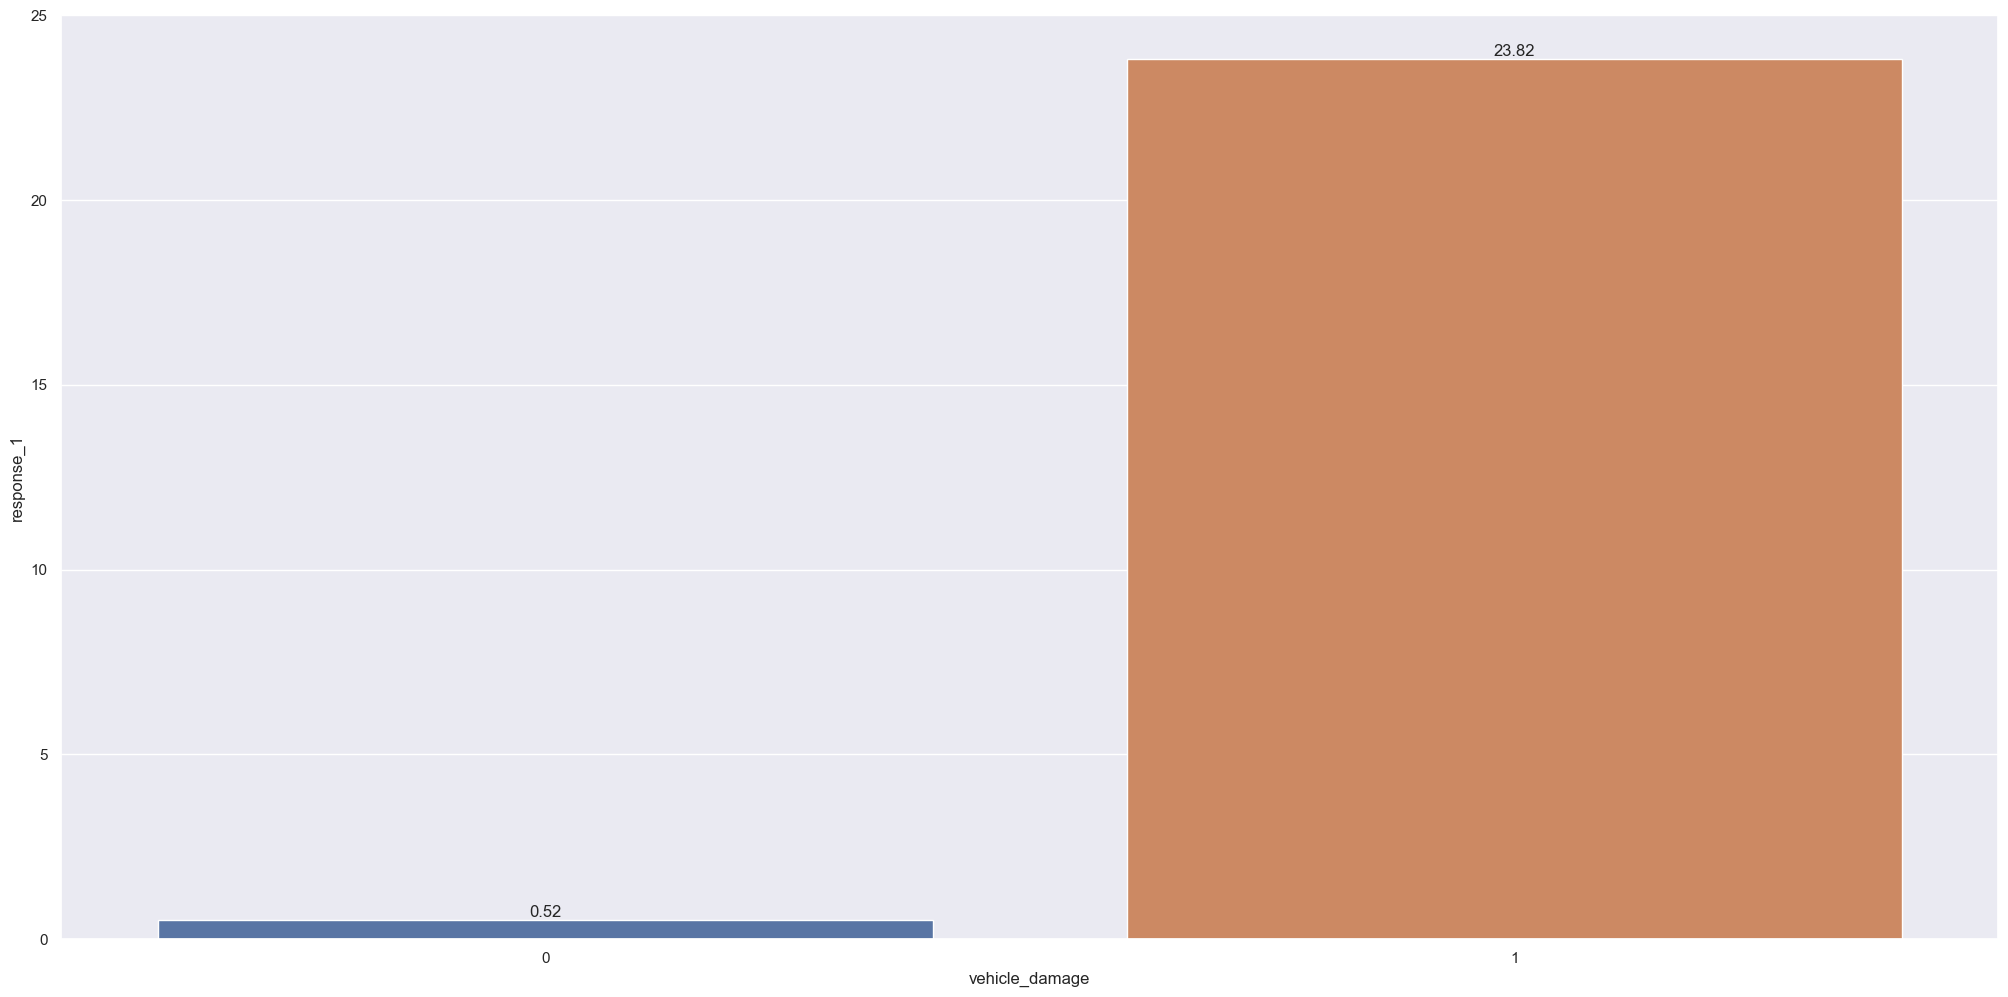

In [36]:
aux = pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()


aux.columns = ['vehicle_damage', 'response_0', 'response_1']
aux[['response_0', 'response_1']] = aux[['response_0', 'response_1']]*100

ax = sns.barplot(data=aux, x='vehicle_damage', y='response_1')
ax.bar_label(ax.containers[0], fmt='%.2f');

**Verdadeiro.** Dentre os clientes que já tiveram o veículo danificado 23,82% possuem um interesse, enquanto apenas 0,52% dos clientes que não tiveram o veículo danificado possuem interesse.

**4.** Clientes que não possuem licença para dirigir estão menos interessados no seguro.

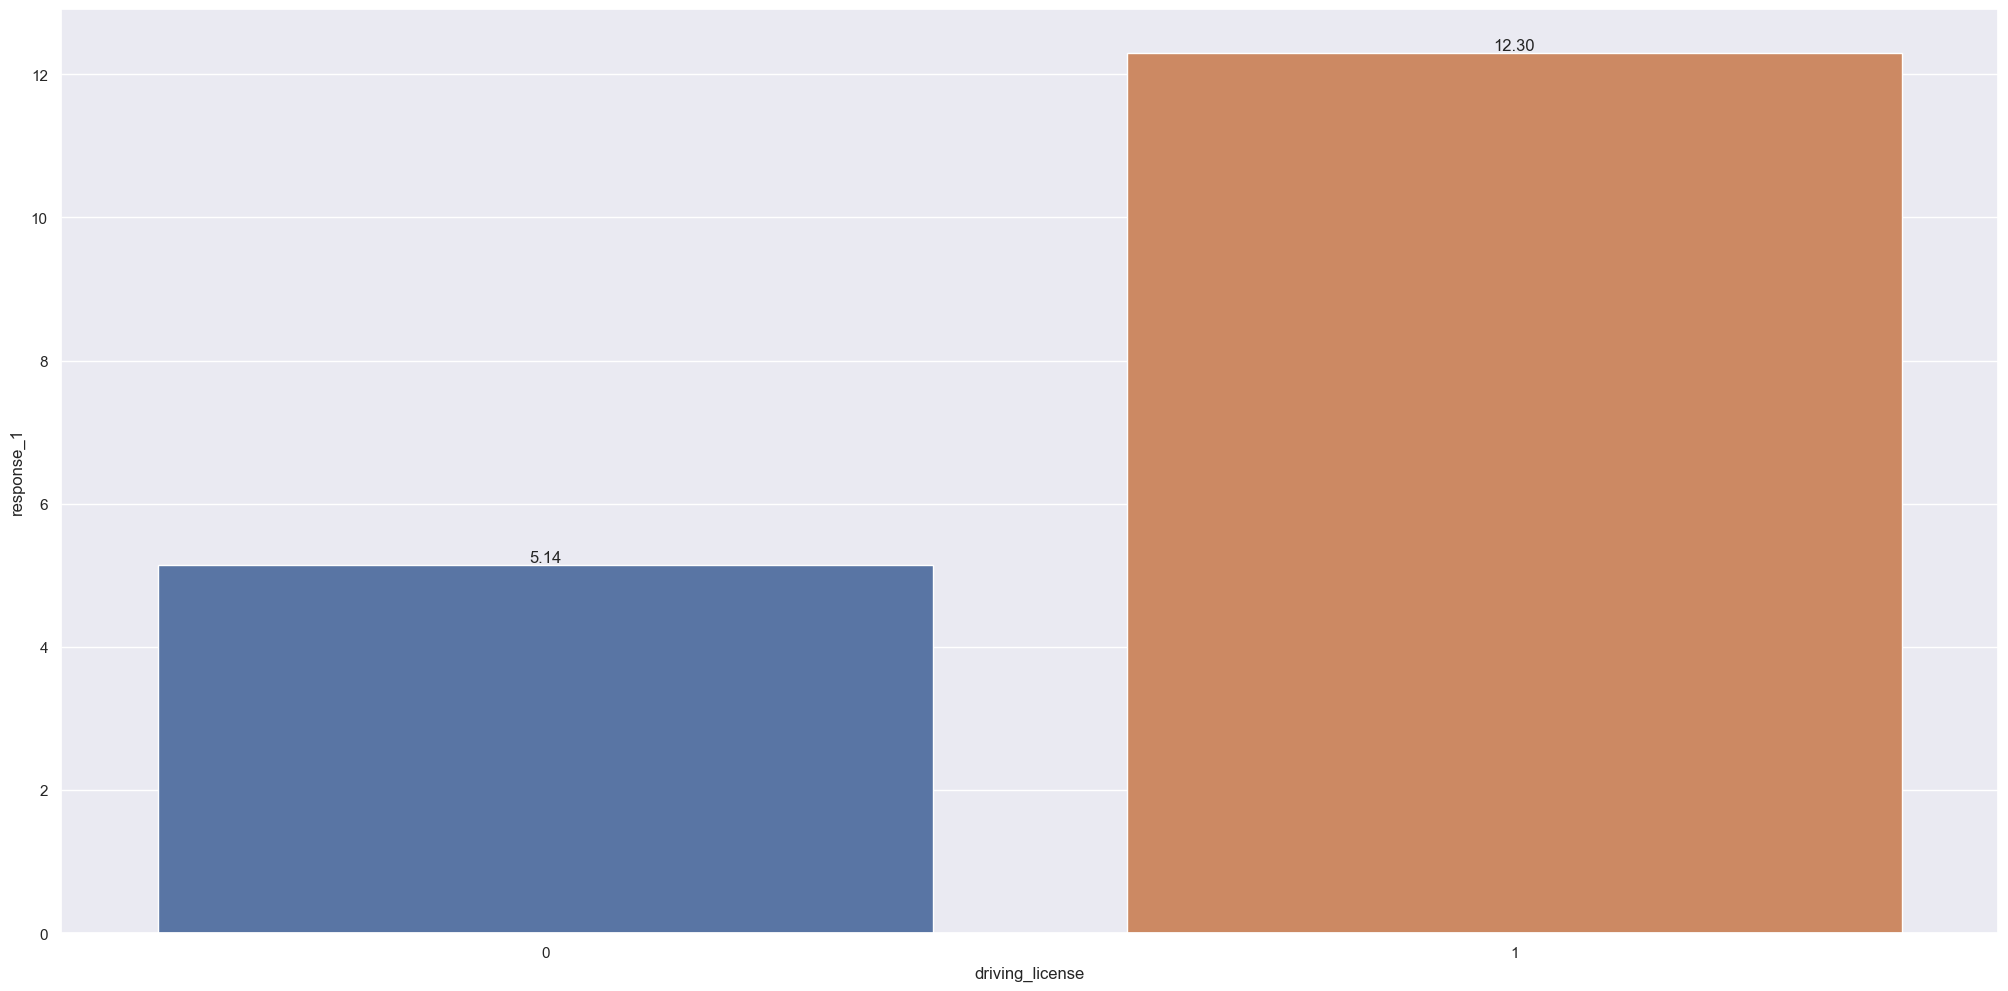

In [37]:
aux = pd.crosstab(df4['driving_license'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()


aux.columns = ['driving_license', 'response_0', 'response_1']
aux[['response_0', 'response_1']] = aux[['response_0', 'response_1']]*100

ax = sns.barplot(data=aux, x='driving_license', y='response_1')
ax.bar_label(ax.containers[0], fmt='%.2f');

**Verdadeiro.** Dentre os clientes que possuem licença 12,30% possuem um interesse, enquanto 5,14% dos clientes que não possuem licença possuem interesse.

**5.** Clientes com maior tempo de associação com a Empresa estão mais interessados no seguro.

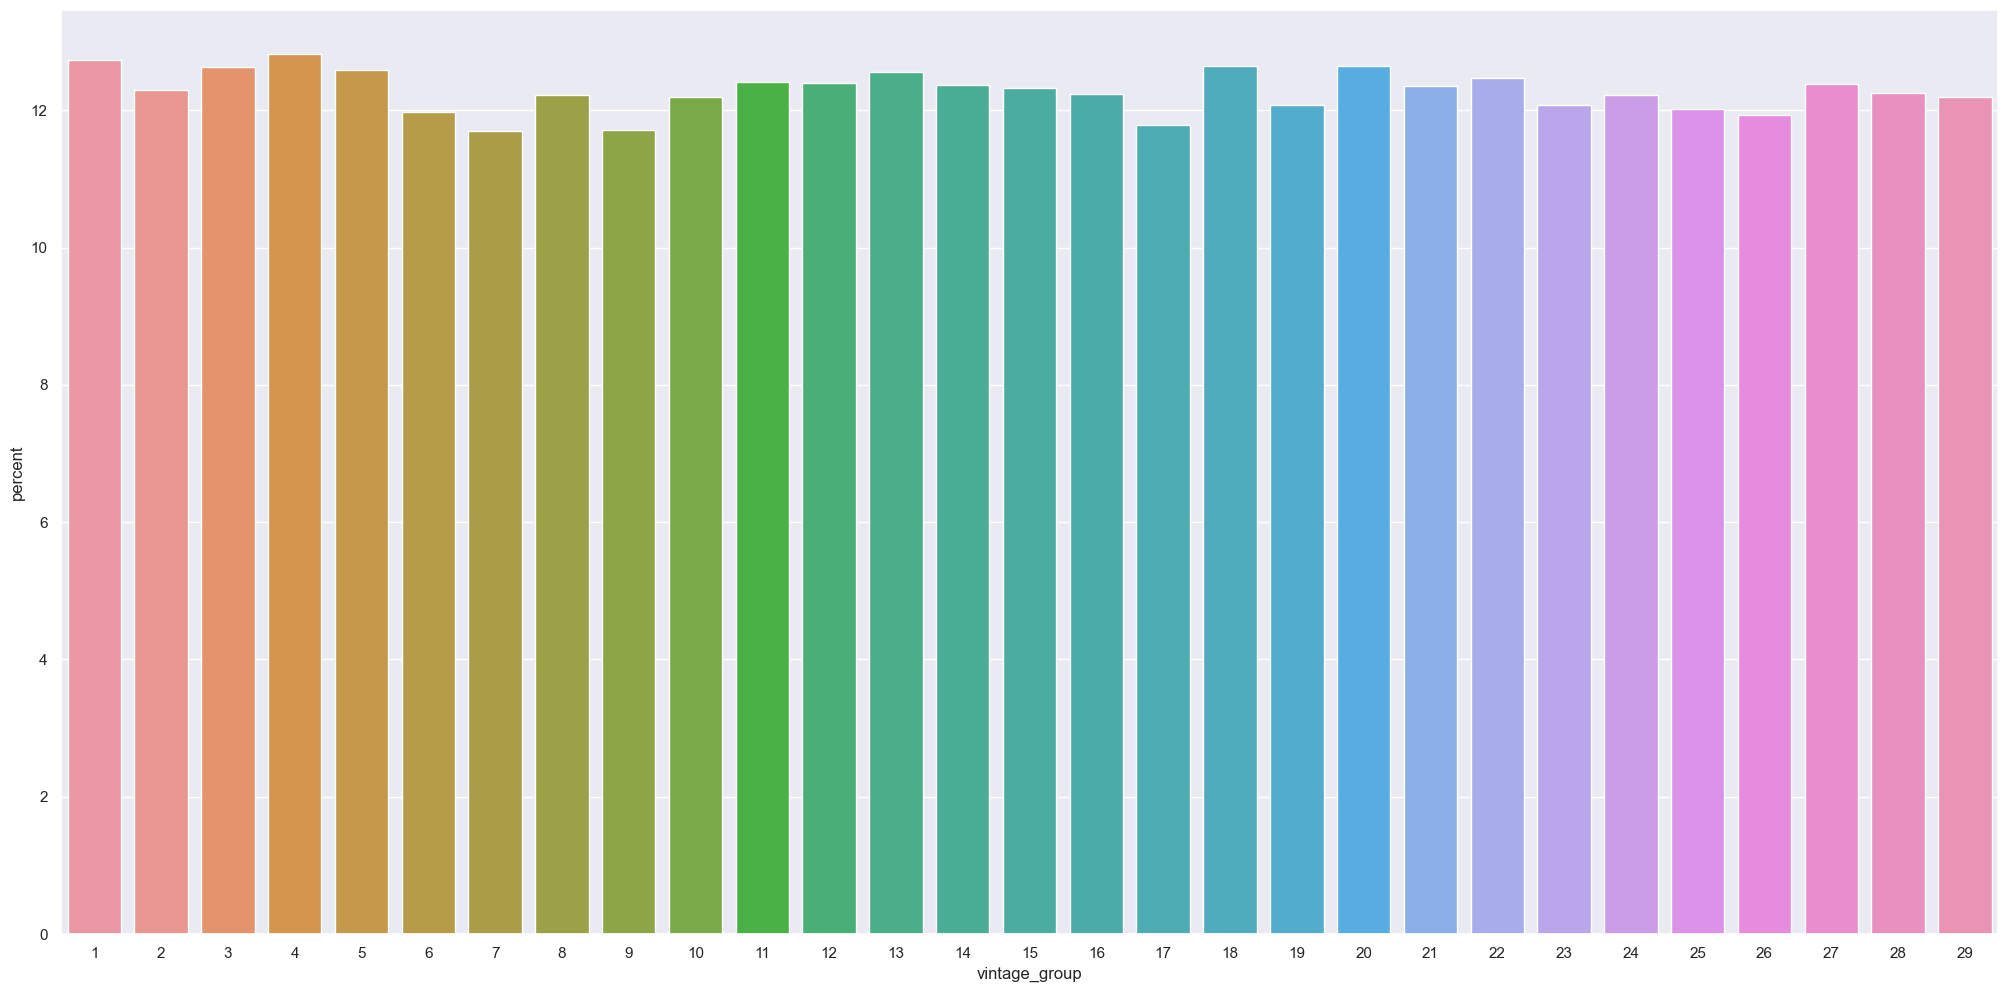

In [38]:
aux = df4[['id', 'vintage_group', 'response']].groupby(['vintage_group', 'response']).count().reset_index()
aux.columns = ['vintage_group', 'response', 'count']
aux1 = aux[aux['response'] == 0].merge(aux[aux['response'] == 1], on = 'vintage_group').drop(['response_x', 'response_y'], axis=1)
aux1.columns = ['vintage_group', 'count_0', 'count_1']
aux1['percent'] = aux1['count_1']*100/(aux1['count_0'] + aux1['count_1'])


sns.barplot(data=aux1, x='vintage_group', y='percent');

**Falso.** Não existem variações significativas no interesse dos clientes em relação ao tempo de associação com a empresa.

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

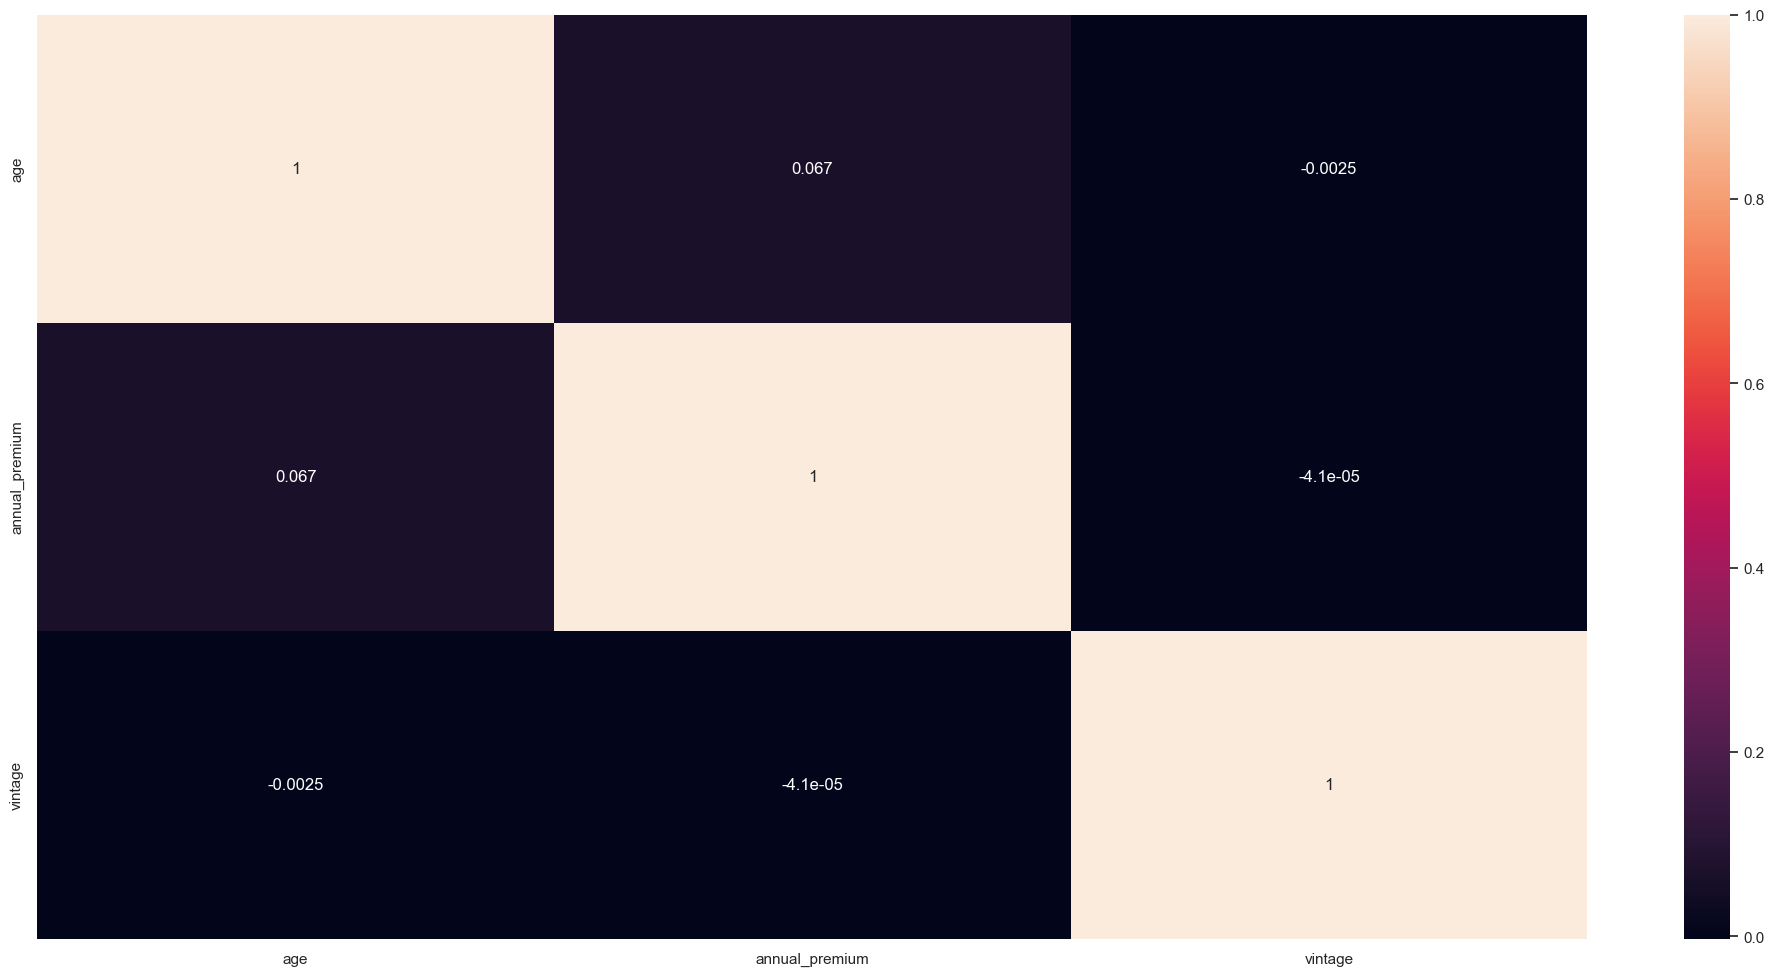

In [41]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

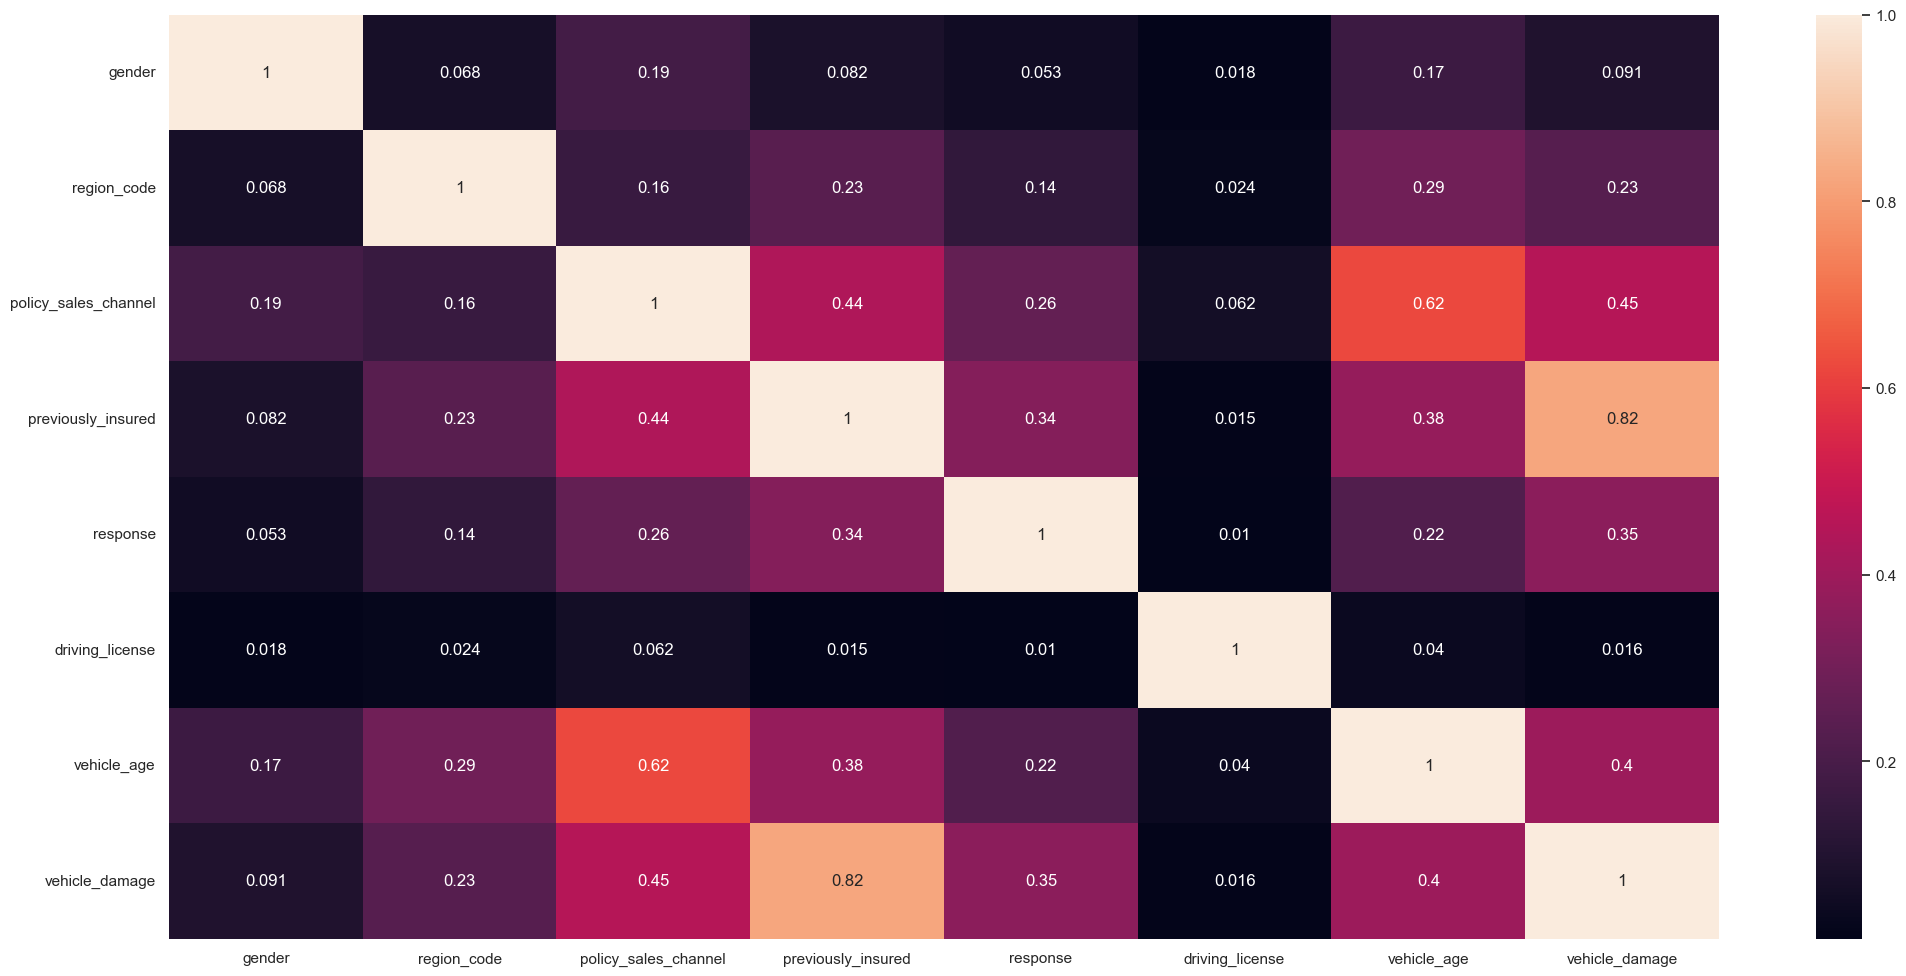

In [42]:
df_correlation = pd.DataFrame()
for feature in list(cat_attributes.columns):
    correlations = []
    for name in list(cat_attributes.columns):
        correlations.append(cramer_v(cat_attributes[feature], cat_attributes[name]))
    df_correlation = pd.concat([df_correlation, pd.Series(correlations)], axis=1)
    
df_correlation.columns = cat_attributes.columns
df_correlation.index = cat_attributes.columns

sns.heatmap( df_correlation, annot=True );

# 5. DATA PREPARATION

In [43]:
df4 = df4.drop(['40yrs_older', 'vintage_group'], axis=1)

## 5.1. Split Dataframe

In [109]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.1)

df5 = pd.concat([x_train, y_train], axis=1)
df_val = pd.concat([x_val, y_val], axis=1)

## 5.2. Standardization

In [45]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open( 'parameter/annual_premium_scaler.pkl', 'wb' ))

## 5.3. Rescaling

In [46]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open( 'parameter/age_scaler.pkl', 'wb' ))

#vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open( 'parameter/vintage_scaler.pkl', 'wb' ))

## 5.4. Transformacao

In [47]:
# gender
te_gender = df5.groupby('gender')['response'].mean()
df5['gender'] = df5['gender'].map(te_gender)
pickle.dump(te_gender, open( 'parameter/target_encoder_gender_scaler.pkl', 'wb' ))

# region_code
te_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(te_region_code)
pickle.dump(te_region_code, open( 'parameter/target_encoder_region_code_scaler.pkl', 'wb' ))

# vehicle_age
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel
te_policy_sales_channel = df5.groupby('policy_sales_channel')['response'].mean()
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(te_policy_sales_channel)
pickle.dump(te_policy_sales_channel, open( 'parameter/target_encoder_policy_sales_channel_scaler.pkl', 'wb' ))

## 5.5 - Validation Preparation

In [48]:
# annual_premium
x_val['annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# age
x_val['age'] = mms_age.transform(x_val[['age']].values)

# vintage
x_val['vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# gender
x_val['gender'] = x_val['gender'].map(te_gender)

# region_code
x_val['region_code'] = x_val['region_code'].map(te_region_code)

# policy_sales_channel
x_val['policy_sales_channel'] = x_val['policy_sales_channel'].map(te_policy_sales_channel)

# vehicle_age
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

In [49]:
x_val.isna().sum()

id                               0
gender                           0
age                              0
region_code                      0
policy_sales_channel             0
previously_insured               0
annual_premium                   0
vintage                          0
driving_license                  0
vehicle_damage                   0
vehicle_age_below_1_year         0
vehicle_age_between_1_2_years    0
vehicle_age_over_2_years         0
dtype: int64

In [47]:
x_val = x_val.fillna(0)

# 6. FEATURE SELECTION

In [50]:
# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values

## 6.1. Boruta as Feature Selector

In [126]:
# define RandomForestClassifier
rf = en.RandomForestClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2).fit(x_train_n.values, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
I

In [127]:
cols_selected_boruta = x_train_n.iloc[:,boruta.support_.tolist()].columns.to_list()
cols_selected_boruta

['age']

## 6.2. Extra Tree as Feature Selector

In [51]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

Feature Ranking:


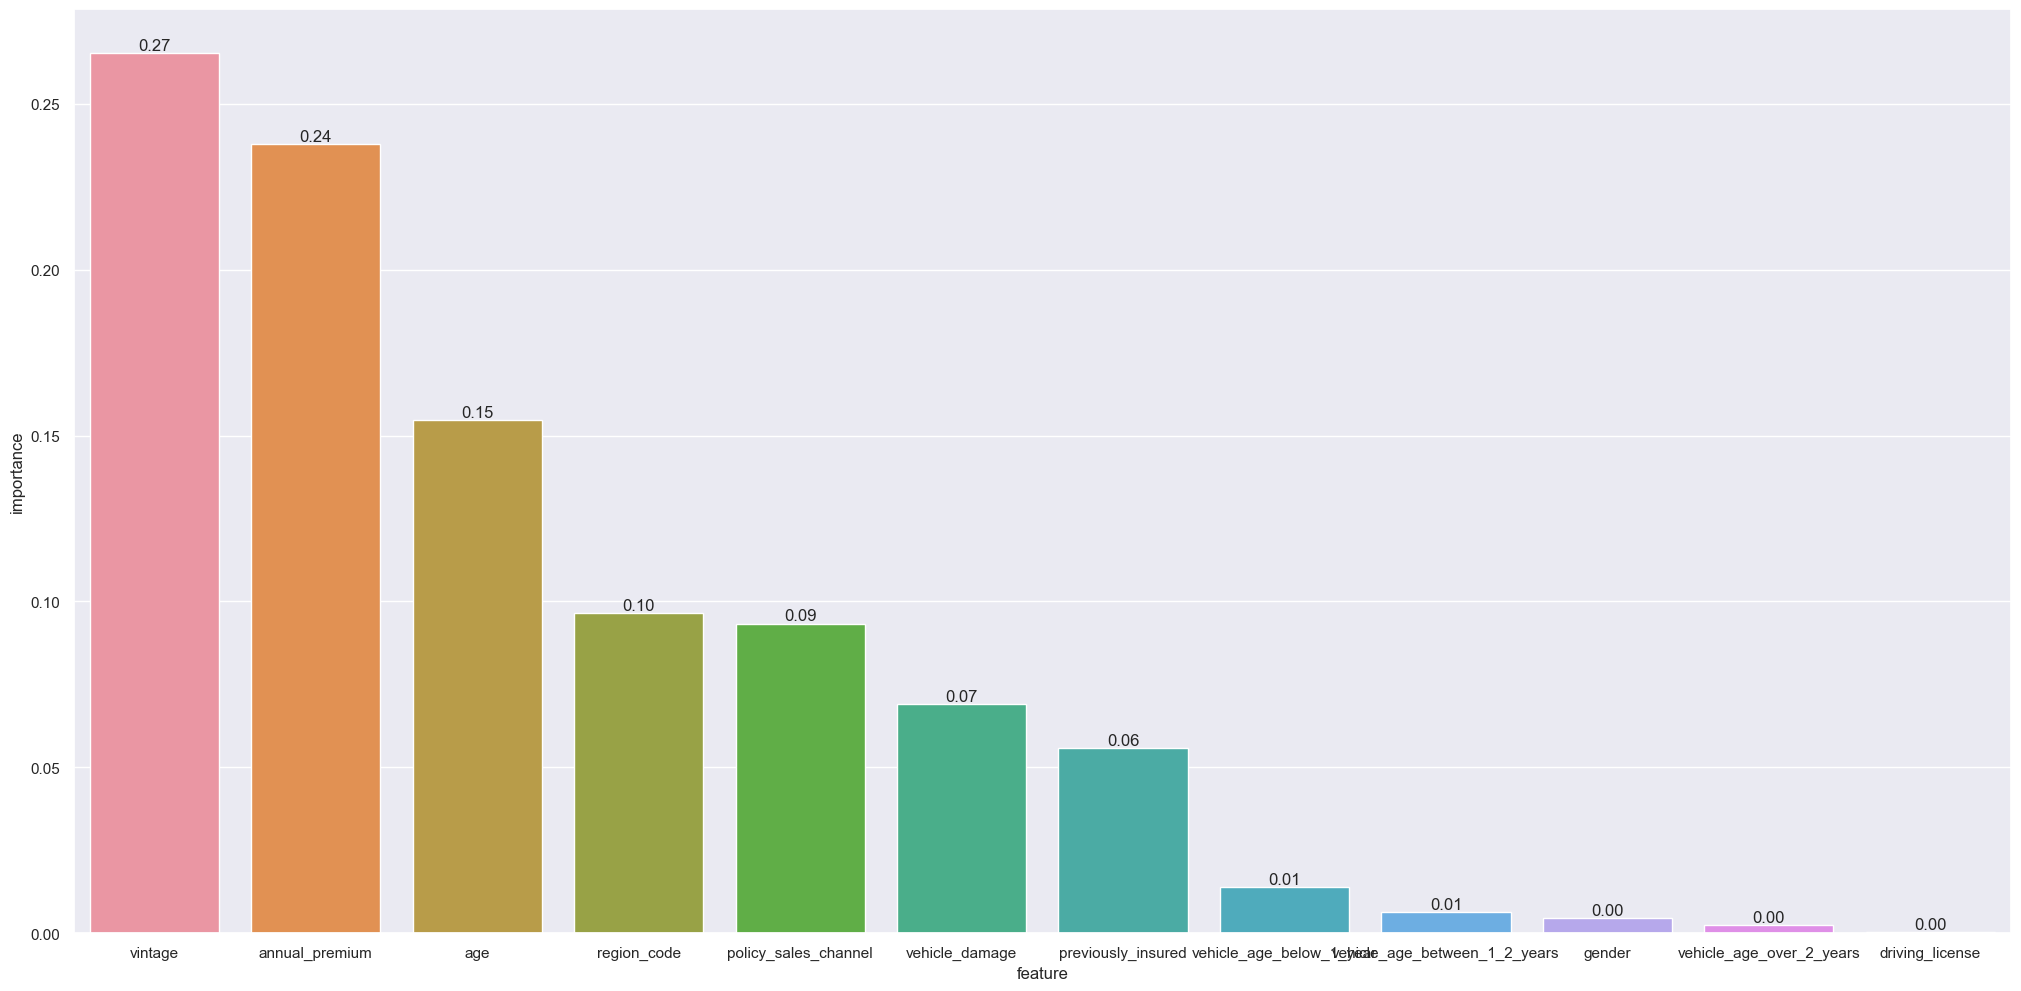

In [52]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_ ], axis=0)

# Print the feature ranking
df_features = pd.DataFrame()
for i, j  in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df_features = pd.concat([df_features, aux], axis=0).sort_values('importance', ascending=False).reset_index(drop=True)

# Plot the impurity-based feature importances of forest
ax = sns.barplot(x='feature', y='importance', data=df_features)
ax.bar_label(ax.containers[0], fmt='%.2f');

In [53]:
# Selecting the columns
cols_selected_extratrees = list(df_features[df_features['importance'] > 0.05]['feature'].values)
cols_selected_extratrees.insert(0, 'id')
cols_selected_extratrees

['id',
 'vintage',
 'annual_premium',
 'age',
 'region_code',
 'policy_sales_channel',
 'vehicle_damage',
 'previously_insured']

In [54]:
cols_selected_extratrees = ['id', 'vintage', 'annual_premium', 'age', 'region_code', 
                            'policy_sales_channel', 'vehicle_damage', 'previously_insured']

# 7.0. MACHINE LEARNING MODELLING

In [55]:
x_train = x_train[cols_selected_extratrees]
x_train_n = x_train.drop('id', axis=1)
x_val = x_val[cols_selected_extratrees]
x_val_n = x_val.drop('id', axis=1)

## 7.1. Logistic Regression

In [56]:
# model definition
lr_model = LogisticRegression(max_iter=1000)

# model fit
lr_model.fit(x_train_n, y_train)

# model predict
yhat_lr = lr_model.predict_proba(x_val_n)

## 7.2. Gaussian Naive Bayes

In [57]:
# model definition
gnb_model = GaussianNB()

# model fit
gnb_model.fit(x_train_n, y_train)

# model predict
yhat_gnb = gnb_model.predict_proba(x_val_n)

## 7.3. ExtraTrees Classfier

In [59]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators=1000)

# model fit
et_model.fit(x_train_n, y_train)

# model predict
yhat_et = et_model.predict_proba(x_val_n)

## 7.4. Random Forest Classfier

In [115]:
# model definition
rf_model = en.RandomForestClassifier(n_estimators=1500, max_depth=5)

# model fit
rf_model.fit(x_train_n, y_train)

# model predict
yhat_rf = rf_model.predict_proba(x_val_n)

## 7.5. LightGBM Classfier

In [116]:
# model definition
lgb_model = LGBMClassifier()

# model fit
lgb_model.fit(x_train_n, y_train)

# model predict
yhat_lgb = lgb_model.predict_proba(x_val_n)

## 7.6. KNeighbors Classifier

In [62]:
# model definition
knn_model = KNeighborsClassifier()

# model fit
knn_model.fit(x_train_n, y_train)

# model predict
yhat_knn = knn_model.predict_proba(x_val_n)

## 7.7. Compares Models Performance

### 7.7.1. Cumulative Gain Curve

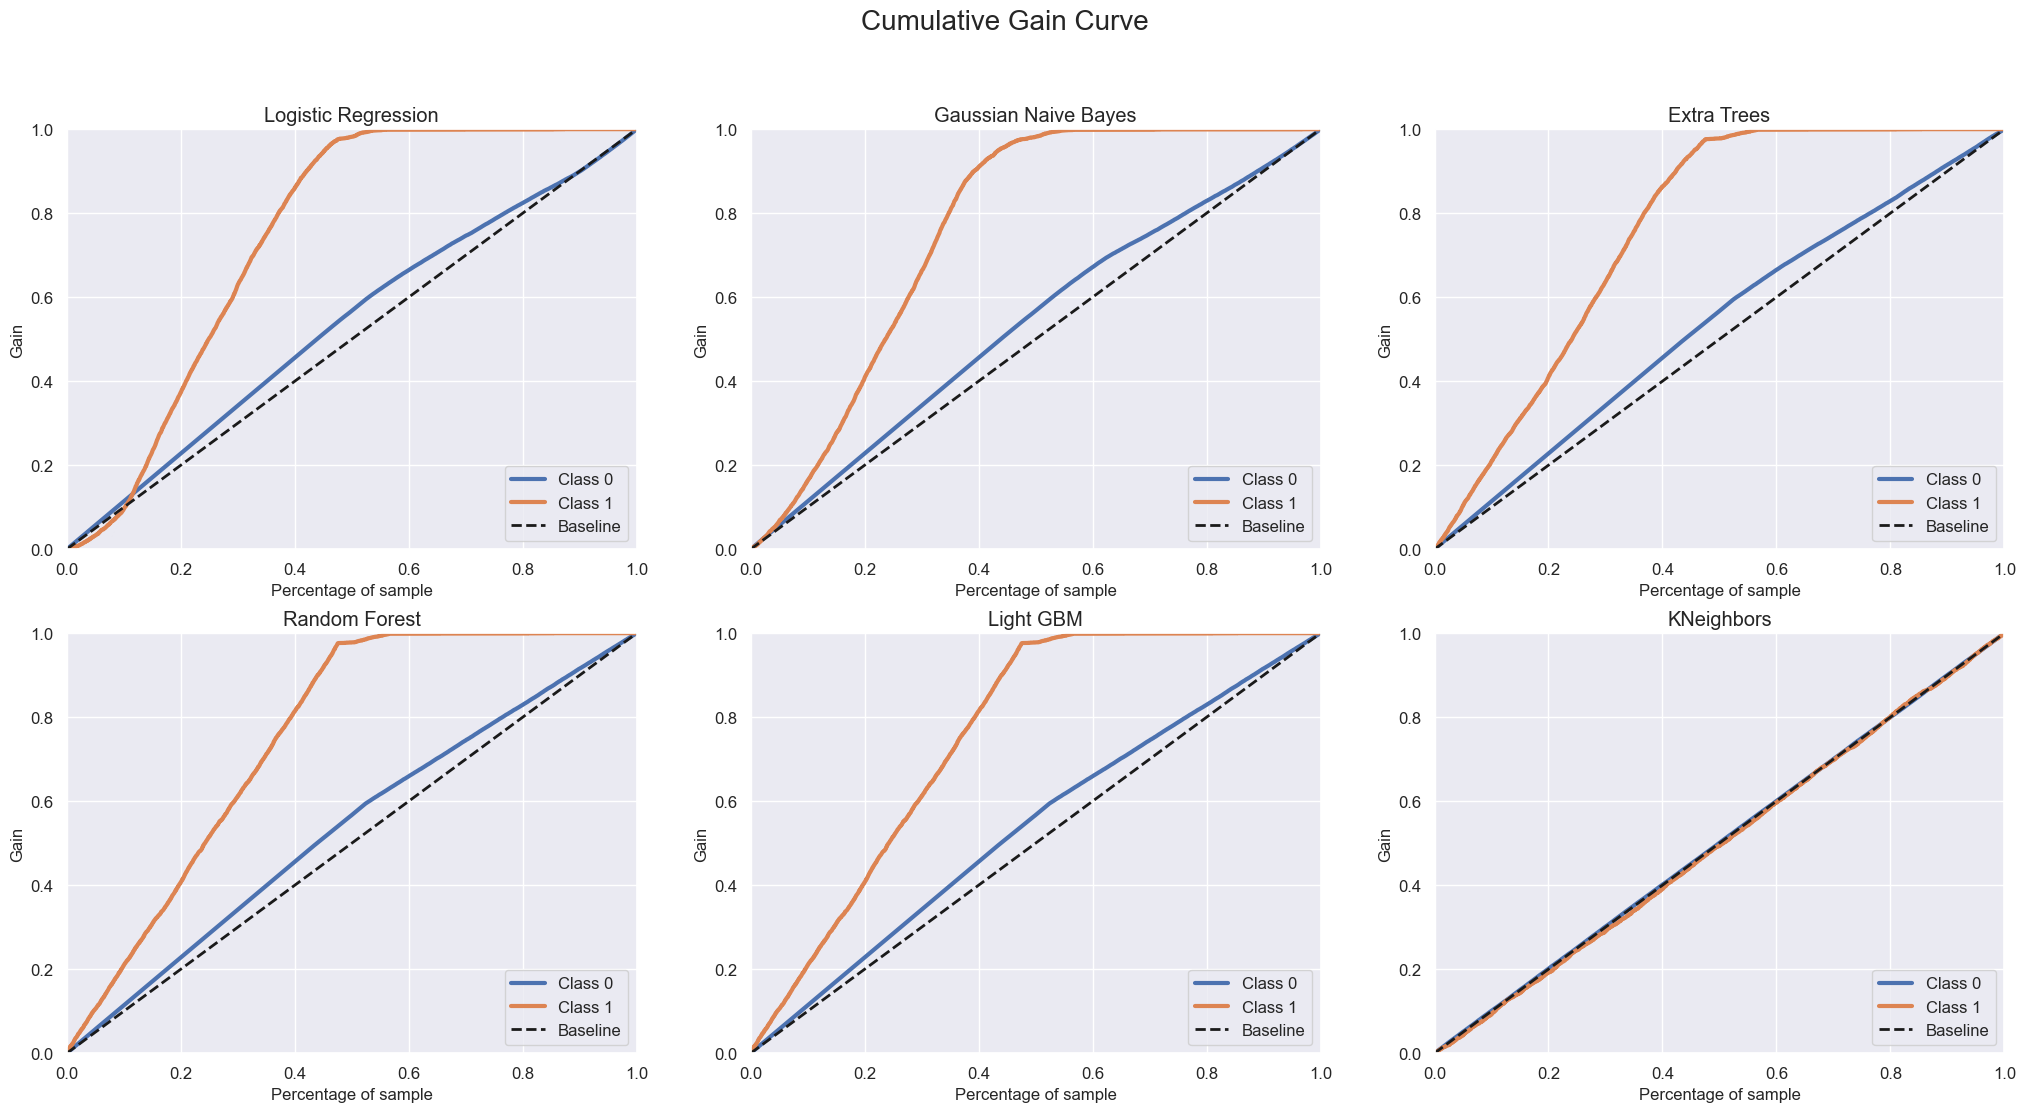

In [117]:
ax = plt.subplot(2,3,1) 
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=ax, title='Logistic Regression')

ax = plt.subplot(2,3,2) 
skplt.metrics.plot_cumulative_gain(y_val, yhat_gnb, ax=ax, title='Gaussian Naive Bayes')

ax = plt.subplot(2,3,3) 
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, ax=ax, title='Extra Trees')

ax = plt.subplot(2,3,4) 
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax=ax, title='Random Forest')

ax = plt.subplot(2,3,5) 
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgb, ax=ax, title='Light GBM')

ax = plt.subplot(2,3,6) 
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=ax, title='KNeighbors')

plt.suptitle("Cumulative Gain Curve", fontsize=20);

### 7.7.2. Lift Curve

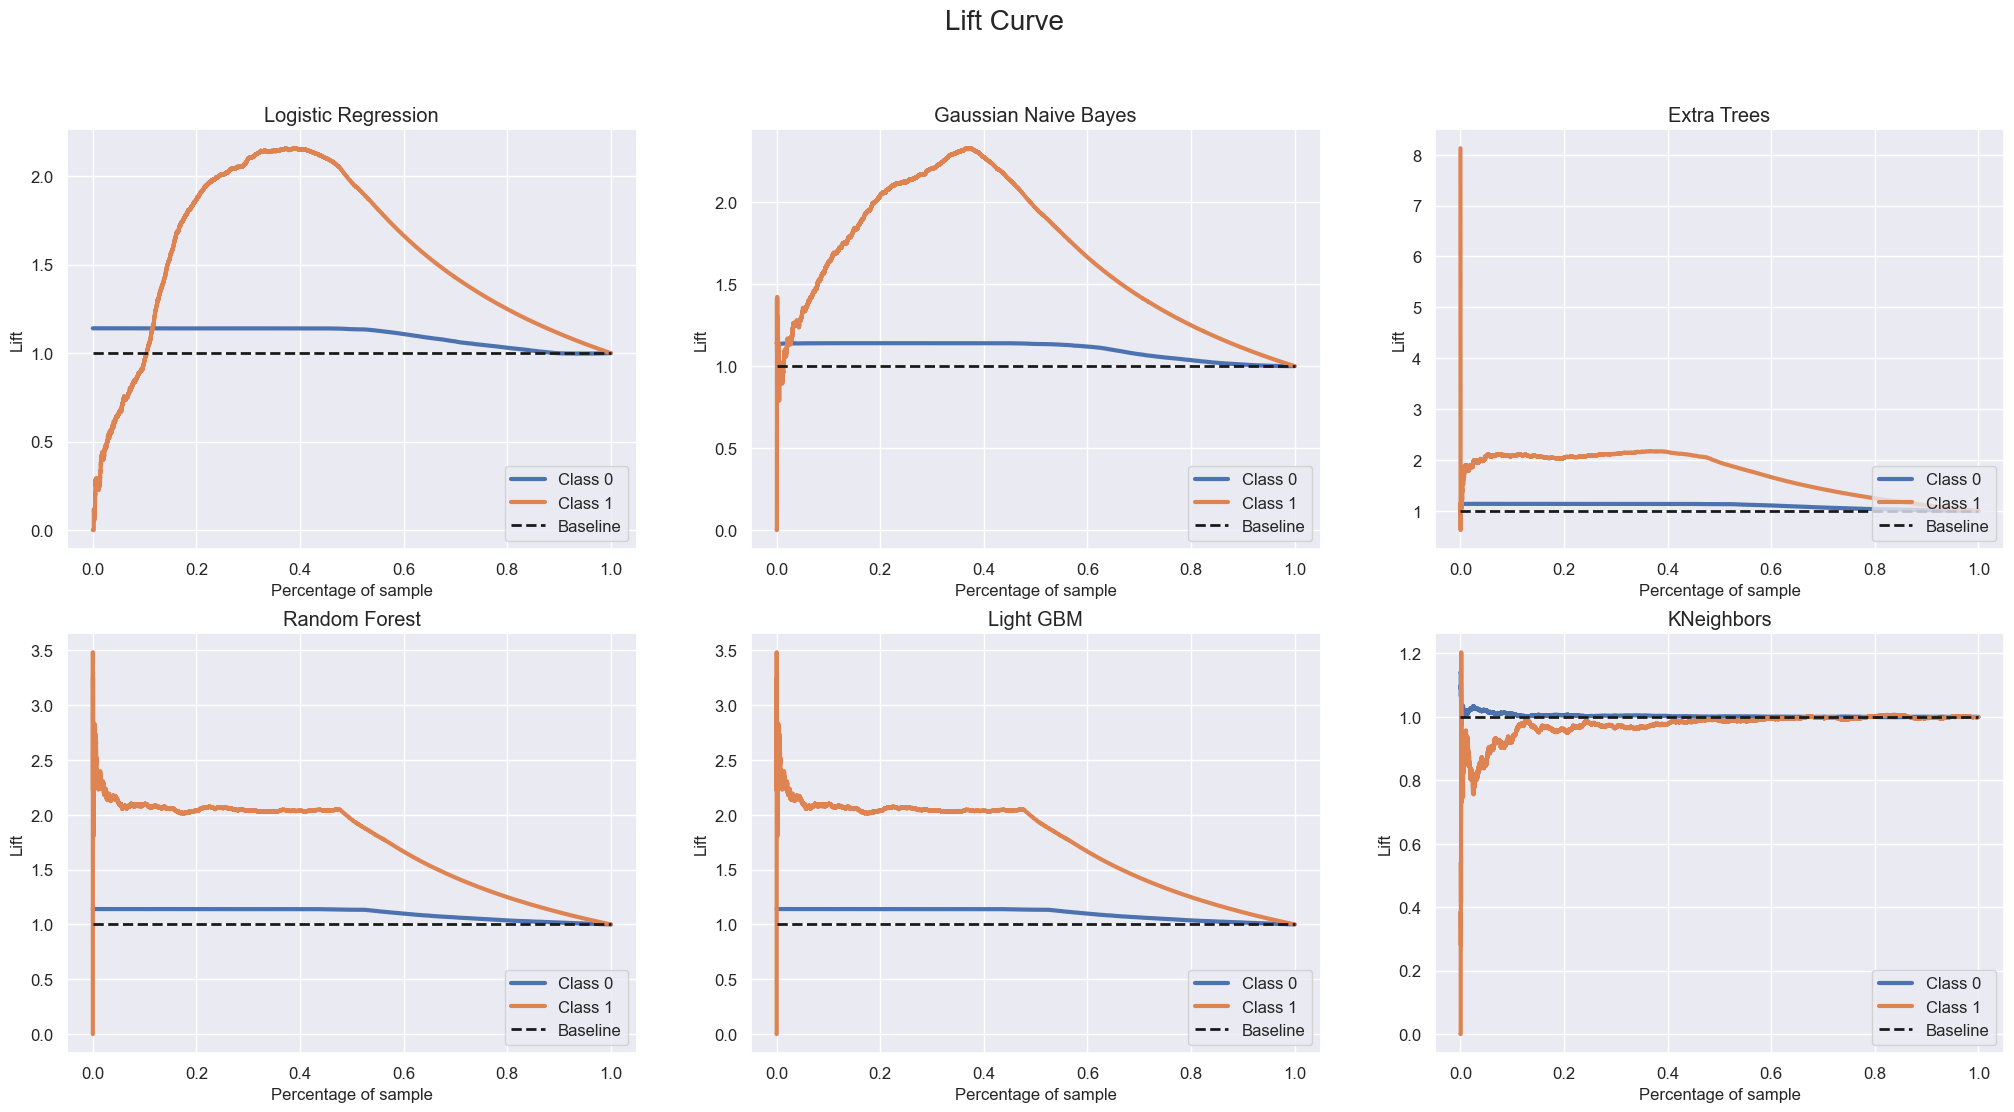

In [118]:
ax = plt.subplot(2,3,1) 
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax=ax, title='Logistic Regression')

ax = plt.subplot(2,3,2) 
skplt.metrics.plot_lift_curve(y_val, yhat_gnb, ax=ax, title='Gaussian Naive Bayes')

ax = plt.subplot(2,3,3) 
skplt.metrics.plot_lift_curve(y_val, yhat_et, ax=ax, title='Extra Trees')

ax = plt.subplot(2,3,4) 
skplt.metrics.plot_lift_curve(y_val, yhat_rf, ax=ax, title='Random Forest')

ax = plt.subplot(2,3,5) 
skplt.metrics.plot_lift_curve(y_val, yhat_lgb, ax=ax, title='Light GBM')

ax = plt.subplot(2,3,6) 
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax=ax, title='KNeighbors')

plt.suptitle("Lift Curve", fontsize=20);

### 7.7.3. Top K Metrics

In [119]:
model_name = ['Logistic Regression', 'Gaussian Naive Bayes', 'Extra Trees',
              'Random Forest', 'Light GBM', 'KNeighbors']

yhat_list = [yhat_lr, yhat_gnb, yhat_et, yhat_rf, yhat_lgb, yhat_knn]

df_metrics = pd.DataFrame()

for model, yhat in zip(model_name, yhat_list):
    df_metrics = pd.concat([df_metrics, model_metrics(model, yhat, df_val)])
    
df_metrics

,Model Name,precision_at_20,recall_at_20,f1_at_20,precision_at_40,recall_at_40,f1_at_40
0,Logistic Regression,0.229996,0.373845,0.284786,0.264558,0.859986,0.404637
0,Gaussian Naive Bayes,0.251130,0.408197,0.310955,0.279936,0.909974,0.428157
0,Extra Trees,0.249381,0.405354,0.308789,0.265505,0.863066,0.406086
0,Random Forest,0.256668,0.417200,0.317813,0.254282,0.826581,0.388920
0,Light GBM,0.256668,0.417200,0.317813,0.254282,0.826581,0.388920
0,KNeighbors,0.121848,0.198057,0.150875,0.124262,0.403933,0.190057


## 7.8. Cross-Validation

# 9.0. DEPLOY

In [30]:
# Save Trained Model
pickle.dump(gnb_model, open( 'model/model_gnb.pkl', 'wb' ))

## 9.1. Health Insurance Class

In [38]:
import inflection
import pandas as pd
import pickle

class HealthInsurance:
    def __init__(self):
        self.homepath = ''
        self.annual_premium_scaler = pickle.load(open(self.homepath + 'parameter/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler = pickle.load(open(self.homepath + 'parameter/age_scaler.pkl', 'rb'))
        self.vintage_scaler = pickle.load(open(self.homepath + 'parameter/vintage_scaler.pkl', 'rb'))
        self.target_encoder_gender_scaler = pickle.load(open(self.homepath + 'parameter/target_encoder_gender_scaler.pkl', 'rb'))
        self.target_encoder_region_code_scaler = pickle.load(open(self.homepath + 'parameter/target_encoder_region_code_scaler.pkl', 'rb'))
        self.target_encoder_policy_sales_channel_scaler = pickle.load(open(self.homepath + 'parameter/target_encoder_policy_sales_channel_scaler.pkl', 'rb'))


    def data_cleaning(self, data):
        cols_old = data.columns
        data.columns = list(map(inflection.underscore, cols_old))
        return data


    def feature_engineering(self, data):
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                                        'between_1_2_years' if x == '1-2 Year' else
                                                        'below_1_year')
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        return data


    def data_preparation(self, data):
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)
        data['age'] = self.age_scaler.transform(data[['age']].values)
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)
        data['gender'] = data['gender'].map(self.target_encoder_gender_scaler)
        data['region_code'] = data['region_code'].map(self.target_encoder_region_code_scaler)
        data = pd.get_dummies(data, prefix='vehicle_age', columns=['vehicle_age'])
        data['policy_sales_channel'] = data['policy_sales_channel'].map(self.target_encoder_policy_sales_channel_scaler)

        cols_selected_extratrees = ['vintage', 'annual_premium', 'age', 'region_code',
                                    'policy_sales_channel', 'vehicle_damage', 'previously_insured']
        return data[cols_selected_extratrees]

    def get_prediction(self, model, original_data, test_data):
        # model predicition
        pred = model.predict_proba(test_data)

        #join prediction into original data
        original_data['score'] = pred[:, 1]

        return original_data.to_json(orient='records', date_format='iso')

## 9.2. API Handler

In [73]:
import pandas as pd
import pickle
import os

from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# loading model
path = ''
model = pickle.load(open(path + 'model/model_gnb.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # mutiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate HealthInsurance Class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # data engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run( '0.0.0.0', port=port)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://192.168.0.19:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

## 9.3. API Tester

In [11]:
df_test = x_val
df_test['response'] = y_val
df_test.to_json('df_test.json')

data = json.dumps(df_test.to_dict(orient='records'))

# API Call
url = 'https://health-insurance-model-ranking.herokuapp.com/predict'
#url = '192.168.0.19:5000/predict'
header = {'Content-type':'application/json'}

r = requests.post(url, data=data, headers=header)
print(f'Status Code: {r.status_code}')

Status Code: 200


In [30]:
df = pd.DataFrame(r.json(), columns=r.json()[0].keys()).sort_values('score', ascending=False, ignore_index=True)
df.head(50)

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response,score
0,100684,0.104086,1.000000,0.186832,26.0,0,0.103100,0.979239,1,below_1_year,0,0,0.006855
1,368757,0.104086,0.953846,0.186832,124.0,0,0.446015,0.062284,1,below_1_year,0,0,0.006814
2,35424,0.138598,0.938462,0.186832,122.0,0,-0.343705,0.335640,1,below_1_year,0,0,0.006801
3,204870,0.138598,0.938462,0.186832,122.0,0,0.636607,0.605536,1,below_1_year,0,0,0.006801
4,203923,0.138598,0.938462,0.186832,26.0,0,-0.032846,0.117647,1,below_1_year,0,0,0.006799
5,343062,0.104086,0.938462,0.186832,26.0,0,-1.623725,0.989619,1,below_1_year,0,0,0.006799
6,157204,0.138598,0.938462,0.186832,26.0,0,-0.153636,1.000000,1,below_1_year,0,0,0.006799
7,284099,0.138598,0.953846,0.126616,26.0,0,-1.623725,0.768166,1,below_1_year,0,0,0.006794
8,300219,0.138598,0.923077,0.186832,60.0,0,-0.224658,0.916955,1,below_1_year,0,0,0.006792
9,91306,0.104086,0.938462,0.163132,26.0,0,-0.243821,0.885813,1,below_1_year,0,0,0.006791


In [22]:
data = df1.sample(20)
data = json.dumps(data.to_dict(orient='records'))

# API Call
url = 'https://health-insurance-model-ranking.herokuapp.com/predict'
#url = '192.168.0.19:5000/predict'
header = {'Content-type':'application/json'}

r = requests.post(url, data=data, headers=header)
print(f'Status Code: {r.status_code}')

df = pd.DataFrame(r.json(), columns=r.json()[0].keys()).sort_values('score', ascending=False, ignore_index=True)
df

Status Code: 200


,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage,score
0,65925,0.104086,0.892308,0.127178,26.0,0,-0.130697,0.456747,0,1,1-2 Year,1,0.033241
1,284198,0.138598,0.538462,0.186832,26.0,0,-1.623725,0.913495,0,1,1-2 Year,1,0.031803
2,78020,0.138598,0.492308,0.186832,26.0,0,10.677351,0.017301,0,1,> 2 Years,1,0.031605
3,275219,0.138598,0.430769,0.097637,26.0,0,-0.066179,0.318339,0,1,1-2 Year,1,0.031226
4,22760,0.138598,0.338462,0.186832,26.0,0,-0.074019,0.217993,0,1,1-2 Year,1,0.030968
5,7083,0.138598,0.307692,0.186832,124.0,0,0.422554,0.477509,1,1,1-2 Year,1,0.030843
6,324553,0.104086,0.338462,0.088791,124.0,0,-1.623725,0.186851,1,1,1-2 Year,1,0.030836
7,304439,0.104086,0.076923,0.086730,152.0,0,-0.238769,0.179931,0,1,< 1 Year,1,0.029822
8,167770,0.104086,0.046154,0.070959,26.0,0,0.041660,0.730104,0,1,< 1 Year,1,0.029621
9,25784,0.138598,0.353846,0.117825,156.0,0,-1.623725,0.681661,0,1,1-2 Year,0,0.006258
